# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки качества моделей применяйте метрику RMSE. Значение метрики RMSE должно быть меньше 2500.


## Введение

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Цель проекта

Целью проекта является разработка моделей предсказания цены автомобиля, их сравнение по качеству предсказания, скорости предсказания, времени обучения, и выбор модели с наилучшими показателями.

Значение метрики RMSE должно быть меньше 2500.


### Основные этапы

В проекте мы выполнили следующее.
1. Исследовательский анализ данных, исправление аномалий и обработку пропусков данных.
1. Обучили разные модели с подбором гиперпараметров. 
1. Проанализиовали время обучения, время предсказания и качество моделей.
1. Выбрали лучшие модели, проверили качество на тестовой выборке.

### Выводы

Мы разработали модели предсказания цены автомобиля и обеспечили заданный уровень качества предсказания. Полученные модели продемонстрировали RMSE на тестовой выборке 1464 и 1481 при требуемом RMSE не более 2500.

Для достижения поставленной цели мы проанализировали данные и определили область применеия модели:
- возраст автомобиля от 4 до 20 лет включительно,
- обязательно наличие информации о типе автомобильного кузова и моодели,
- мощность автомобиля от 50 до 250 лс включительно,
- минимальная стоимость 300 евро.

Мы сравнили 4 модели по качеству предсказания, времени обучения и времени предсказания и выбрали две сопоставимые по качеству, отличающиеся по времени обучения и предсказания. Выбор между финальными моделями можно сделать исходя из приоритетов качества предсказания, времени обучения и времени предсказания.

## Подготовка кода

### Загрузка библиотек

In [1]:
from os import path

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, validation_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor

In [6]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [7]:
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [8]:
RANDOM_STATE = np.random.RandomState(2575215) 

In [9]:
from urllib.request import urlopen
import pickle

### Функции

#### Очистка данных

In [10]:
def remove_duplicates(_df: pd.DataFrame) -> pd.DataFrame:
    """Удаляет дубликаты"""

    return _df.drop_duplicates().reset_index(drop=True)


def remove_empty_price_rows(_df: pd.DataFrame) -> pd.DataFrame:
    """Удаляет строки с пропусками в Price"""

    return _df.query('Price > 0')


def filter_price(_df: pd.DataFrame) -> pd.DataFrame:
    """Удаляет строки с Price < 300"""

    return _df.query('Price >= 300')


def convert_str_to_datetime(_df: pd.DataFrame) -> pd.DataFrame:
    """Заменяет строковый тип у признаков `DateCreated` и `DateCrowled` на DateTime"""

    for column in ['DateCreated', 'DateCrawled', 'LastSeen']:
        _df[column] = pd.to_datetime(
            _df[column], format='%Y-%m-%d %H:%M:%S').dt.round(freq='D')

    return _df


def add_car_age_feature(_df: pd.DataFrame) -> pd.DataFrame:
    """Добавляет расчетный признак возраст автомобиля CarAge"""

    _df.loc[:, 'CarAge'] = round(
        (_df.DateCreated.dt.year * 12 + _df.DateCreated.dt.month -
         _df.RegistrationYear * 12 - _df.RegistrationMonth) / 12).astype('int')

    return _df


def add_brandmodel_feature(_df: pd.DataFrame) -> pd.DataFrame:
    """Добавляет расчетный признак BrandModel"""

    _df.loc[:, 'BrandModel'] = _df.Brand + _df.Model

    return _df


def add_anketa_age_feature(_df: pd.DataFrame) -> pd.DataFrame:
    """Добавляет расчетный признак возраст анкеты AnketaAge"""

    _df.loc[:, 'AnketaAge'] = (_df.DateCrawled -
                               _df.DateCreated).astype('timedelta64[D]')

    return _df


def fill_na_with_unknown(_df: pd.DataFrame) -> pd.DataFrame:
    """Заполняет пропуски в категориальных признаках значением unknown"""

    return _df.fillna('unknown')


def replace_negative_age(_df: pd.DataFrame) -> pd.DataFrame:
    """Заменяет отрицательный возраст на 0"""

    _df.CarAge = np.where(_df.CarAge < 0, 0, _df.CarAge)

    return _df


def replace_age_over_40(_df: pd.DataFrame) -> pd.DataFrame:
    """Заменяет возраст старше 40 на 40"""

    _df.CarAge = np.where(_df.CarAge > 40, 40, _df.CarAge)

    return _df


def replace_power_outliers(_df: pd.DataFrame) -> pd.DataFrame:
    """Заменяет вылеты на NaN"""

    _df.Power = np.where((_df.Power < 50) | (_df.Power > 250), np.NaN,
                         _df.Power)

    return _df


def drop_na_rows_model_type(_df: pd.DataFrame) -> pd.DataFrame:
    """Удаляет строки с пропусками значений в признаках Model & VehicleType"""

    return _df.dropna(axis=0, how="any", subset=["Model", "VehicleType"])


def drop_na_rows_power(_df: pd.DataFrame) -> pd.DataFrame:
    """Удаляет строки с пропусками значений в признаке Power"""

    return _df.dropna(axis=0, how="any", subset=["Power"])


def filter_age(_df: pd.DataFrame) -> pd.DataFrame:
    """Фильтрует возраст автомобиля от 3 до 21 годв"""

    return _df.query('3 < CarAge < 21')


def drop_unused_features(_df: pd.DataFrame) -> pd.DataFrame:

    return _df.drop(labels=[
        'DateCrawled', 'RegistrationYear', 'BrandModel', 'RegistrationMonth',
        'DateCreated', 'NumberOfPictures', 'LastSeen'
    ],
                    axis=1)

#### CarPower

In [11]:
class CarPower:
    def __init__(self):
        self.cars = dict()

    def fit(self, _df: pd.DataFrame) -> None:
        self.cars = (_df.query('50 <= Power <= 250')[[
                'BrandModel', 'Power'
            ]].groupby(by='BrandModel').mean().to_dict('index'))

    def getPower(self, car: str) -> float:
        if car in self.cars:
            return self.cars[car]['Power']
        else:
            return np.NaN

    def transform(self, _df: pd.DataFrame) -> pd.DataFrame:
        columns = _df.columns
        _df.loc[_df.Power.isna(), 'Power'] = _df.loc[
            _df.Power.isna(), 'BrandModel'].apply(lambda x: self.getPower(x))
        return _df[columns]

In [12]:
def clear_data(_df: pd.DataFrame, steps: list) -> pd.DataFrame:
    for step in steps:
        _df = step(_df)
    
    return _df

#### cross_validate_model

In [13]:
def cross_validate_model(estimator, X, y, verbose=True, fit_params=dict()):
    cv_results = cross_validate(estimator,
                                X,
                                y,
                                cv=cv,
                                return_train_score=True,
                                scoring=['r2', 'neg_root_mean_squared_error'],
                                fit_params=fit_params,
                                n_jobs=-1)
    if verbose:
        print(
            f"""fit time\t {cv_results['fit_time'].mean():.2f}s +/- {cv_results['fit_time'].std():.2f}s
score time\t {cv_results['score_time'].mean():.2f}s +/- {cv_results['score_time'].std():.2f}s
RMSE\t\t {-cv_results['test_neg_root_mean_squared_error'].mean():.0f} +/- {-cv_results['test_neg_root_mean_squared_error'].std():.0f}
R2 \t\t {cv_results['test_r2'].mean():.3f} +/- {cv_results['test_r2'].std():.3f}
""")

    return cv_results

#### get_cv_result

In [14]:
def get_cv_result(X, y, numerical, categorical, cv):
    est = make_pipeline(
        ColumnTransformer(
            [('categorical', OneHotEncoder(
                dtype='int', handle_unknown='ignore'), categorical),
             ('numerical', StandardScaler(), numerical)],
            remainder='drop'), LinearRegression(n_jobs=-1))

    cv_results = cross_validate_model(est, X, y, verbose=False)

    return cv_results['test_r2'].mean()

#### get_scoring_values

In [15]:
def get_scoring_values(_data, param_name):
    return np.array([ value[param_name] for _, value in _data.items() ])


#### plot_comaprison_bar

In [16]:
def plot_comaprison_bar(ax, data, errors, y_labels, x_label, xlim=None):
    ax.barh(y_labels, data, xerr=errors, capsize=5)
    ax.set_xlabel(x_label)
    ax.grid(True)
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])

#### load_object

In [17]:
STORAGE_URL = "https://storage.yandexcloud.net/praktikumds/yp13/"

def load_object(file_path):
    url = STORAGE_URL + file_path
    return pickle.load(urlopen(url))

#### save_object

In [18]:
def save_object(file_path, obj):
    with open(file_path, "wb") as file:
        pickle.dump(obj, file)

#### plot_searh_curve


In [19]:
def plot_searh_curve(df: pd.DataFrame, ax: plt.axes, model_name: str) -> None:
    ax.set_title(model_name.upper())
    ax.set_ylabel("RMSE")
    ax.set_xlabel("experiment number")
    x_range = range(df.shape[0])
    ax.grid(True)

    ax.plot(x_range,
            -1 * df.mean_train_score,
            'r-',
            lw=3,
            marker='o',
            markersize=9,
            label='train mean')
    ax.fill_between(x_range,
                    -1 * df.mean_train_score - df.std_train_score,
                    -1 * df.mean_train_score + df.std_train_score,
                    alpha=0.2,
                    color='red',
                    label='train std')

    ax.plot(x_range,
             -1 * df.mean_test_score,
            'g-',
            lw=3,
            marker='o',
            markersize=9,
            label='valid mean')
    ax.fill_between(x_range,
                     -1 * df.mean_test_score - df.std_test_score,
                     -1 * df.mean_test_score + df.std_test_score,
                    alpha=0.2,
                    color='green',
                    label='valid std')
    ax.legend(loc='upper left')

    ax2 = ax.twinx()
    ax2.plot(x_range, df.mean_fit_time, lw=3, alpha=.5, label='fit time')
    ax2.plot(x_range, df.mean_score_time, lw=3, alpha=.5, label='score time')
    ax2.set_ylabel('time, s')
    ax2.legend(loc='upper right')

## Подготовка данных

### Загрузка данных

In [20]:
remote_path = 'https://code.s3.yandex.net/datasets/autos.csv'
local_path = path.join('.', 'data', 'autos.csv')

if path.isfile(local_path):
    data = pd.read_csv(local_path, index_col=0)
else:
    data = pd.read_csv(remote_path)
    if path.exists(path.dirname(local_path)):
        data.to_csv(local_path)
        
data.shape

(354369, 16)

Данные загружены, 354 тысячи объектов и 16 признаков.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Видим, что признаки представлены целыми числами и строками, среди которых есть дата-время. Есть признаки с пропусками значений.

### Описание данных

#### Признаки
1. `DateCrawled` — дата скачивания анкеты из базы
1. `VehicleType` — тип автомобильного кузова
1. `RegistrationYear` — год регистрации автомобиля
1. `Gearbox` — тип коробки передач
1. `Power` — мощность (л. с.)
1. `Model` — модель автомобиля
1. `Kilometer` — пробег (км)
1. `RegistrationMonth` — месяц регистрации автомобиля
1. `FuelType` — тип топлива
1. `Brand` — марка автомобиля
1. `NotRepaired` — была машина в ремонте или нет
1. `DateCreated` — дата создания анкеты
1. `NumberOfPictures` — количество фотографий автомобиля
1. `PostalCode` — почтовый индекс владельца анкеты (пользователя)
1. `LastSeen` — дата последней активности пользователя

#### Целевой признак
16. `Price` — цена (евро)

In [22]:
data.head().T

,0,1,2,3,4
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20
Price,480,18300,9800,1500,3600
VehicleType,NaN,coupe,suv,small,small
RegistrationYear,1993,2011,2004,2001,2008
Gearbox,manual,manual,auto,manual,manual
Power,0,190,163,75,69
Model,golf,NaN,grand,golf,fabia
Kilometer,150000,125000,125000,150000,90000
RegistrationMonth,0,5,8,6,7
FuelType,petrol,gasoline,gasoline,petrol,gasoline


Данные в столбцах соответствуют их смыслу.

### Разделение выборок

Будем придреживаться принципа, согласно которому мы не должны видеть тестовые данные до этапа тестирования моделей. Поэтому выделим данные для теста до исследовательского анализа. Для теста оставим 20% даных.

In [23]:
X = data.drop('Price', axis=1)
y = data.Price
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=RANDOM_STATE)

In [24]:
X_train.shape, y_train.shape

((283495, 15), (283495,))

In [25]:
X_test.shape, y_test.shape

((70874, 15), (70874,))

Сравним статистики обучающей и тестовой выборок целевого признака.

In [26]:
y_train.describe()

count    283495.000000
mean       4418.662618
std        4515.793605
min           0.000000
25%        1090.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [27]:
y_test.describe()

count    70874.000000
mean      4408.633434
std       4507.635140
min          0.000000
25%       1000.000000
50%       2700.000000
75%       6400.000000
max      20000.000000
Name: Price, dtype: float64

Статистики целевого признака на обучающей и тестовой выборке похожи. Разделение данных выполнено корректно.

### Исследовательский анализ

Объединим признаки с целевым признаком в один датасет для анализа.

In [28]:
df = X_train.join(y_train).copy()

#### Обзор структуры данных

In [29]:
df.shape

(283495, 16)

Наша обучающая выборка содержит 283 495 объектов и 16 признаков, включая целевой.

In [30]:
pd.value_counts(df.dtypes)

object    9
int64     7
dtype: int64

В данных 7 признаков целочисленные, а значит не содержат явных пропусков (`np.nan`), так как `np.nan` имеет тип float.

9 признаков имеют тип object, то есть могут быть либо строковыми, либо DateTime в строковом представлении. Эти признаки могут содержать явные пропуски.

##### Обзор нечисловых признаков

In [31]:
df.select_dtypes(exclude='number').head()

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
101208,2016-03-14 16:36:23,wagon,auto,a4,gasoline,audi,no,2016-03-14 00:00:00,2016-04-05 20:44:33
310706,2016-03-18 18:50:46,sedan,manual,c_klasse,petrol,mercedes_benz,no,2016-03-18 00:00:00,2016-04-05 22:45:35
300927,2016-03-28 18:57:08,wagon,manual,astra,gasoline,opel,yes,2016-03-28 00:00:00,2016-03-30 10:45:46
85351,2016-03-28 19:56:45,convertible,manual,cooper,petrol,mini,no,2016-03-28 00:00:00,2016-04-07 02:17:57
134306,2016-03-30 16:38:18,sedan,manual,golf,petrol,volkswagen,no,2016-03-30 00:00:00,2016-04-07 07:15:51


3 из 9 признаков представляют дату и время: `DateCrawled`, `DateCreated`, `LastSeen`.

In [32]:
datetime_columns = ['DateCrawled', 'DateCreated', 'LastSeen']

Преобразуем эти признаки к типу DateTime, округлив до дней.

In [33]:
for column in datetime_columns:
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S').dt.round(freq='D')

df[datetime_columns].head()

,DateCrawled,DateCreated,LastSeen
101208,2016-03-15,2016-03-14,2016-04-06
310706,2016-03-19,2016-03-18,2016-04-06
300927,2016-03-29,2016-03-28,2016-03-30
85351,2016-03-29,2016-03-28,2016-04-07
134306,2016-03-31,2016-03-30,2016-04-07


Отметим, что в примере данных разница между датой скачивания объявления и датой его создания составляет один день. 

Остальные признаки являются категориальными.

In [34]:
categorical_columns = [
    _ for _ in df.select_dtypes(exclude='number').columns.to_list()
    if _ not in datetime_columns
]
categorical_columns

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [35]:
df[categorical_columns].describe()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,253551,267581,267676,257141,283495,226492
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,73198,214427,23398,172778,61710,197636


Хоть vw golf и самая популярная модель, это не помешало седанам занять первенство среди типов кузова :)

Мы ожидаемо видим бинарные признаки "тип коробки передач" и "была в ремонте". 

В данных 40 значений призака "Марка", 250 значений моделей и 8 типов кузова. Учитывая, что значения представленны строками, на этапе оценки качества данных проверим эти признаки на неявные дубликаты.

7 типов топлива выглядит неожиданно много. Также изучим этот признак детальнее на этапе оценки качества данных.

##### Обзор числовых признаков

In [36]:
numerical_columns = df.select_dtypes(include='number').columns.to_list()

In [37]:
df[numerical_columns].describe()

,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,Price
count,283495.000000,283495.000000,283495.000000,283495.000000,283495.0,283495.000000,283495.000000
mean,2004.197016,109.849359,128264.872396,5.715660,0.0,50544.563731,4418.662618
std,88.520975,181.446047,37883.086252,3.724722,0.0,25764.766165,4515.793605
min,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,0.000000
25%,1999.000000,69.000000,125000.000000,3.000000,0.0,30167.000000,1090.000000
50%,2003.000000,105.000000,150000.000000,6.000000,0.0,49477.000000,2700.000000
75%,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000,6400.000000
max,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,20000.000000


Мы видим, что признак `NumberOfPictures` содержит только нули, поэтому нам он не понадобится.

In [38]:
numerical_columns.remove('NumberOfPictures')

Видим, что значения "год регистрации" находятся в диапазоне 1000–9999, что говорит о присутствии  ошибочных значений. У половины объектов год регистрации находится в диапазоне 1999–2008.

Также отметим наличие неявных пропусков в признаках "мощность", "месяц регистрации" и "цена": минимальное значение этих признаков равно нулю.

Посморим на количество уникальных значений числовых признаков.

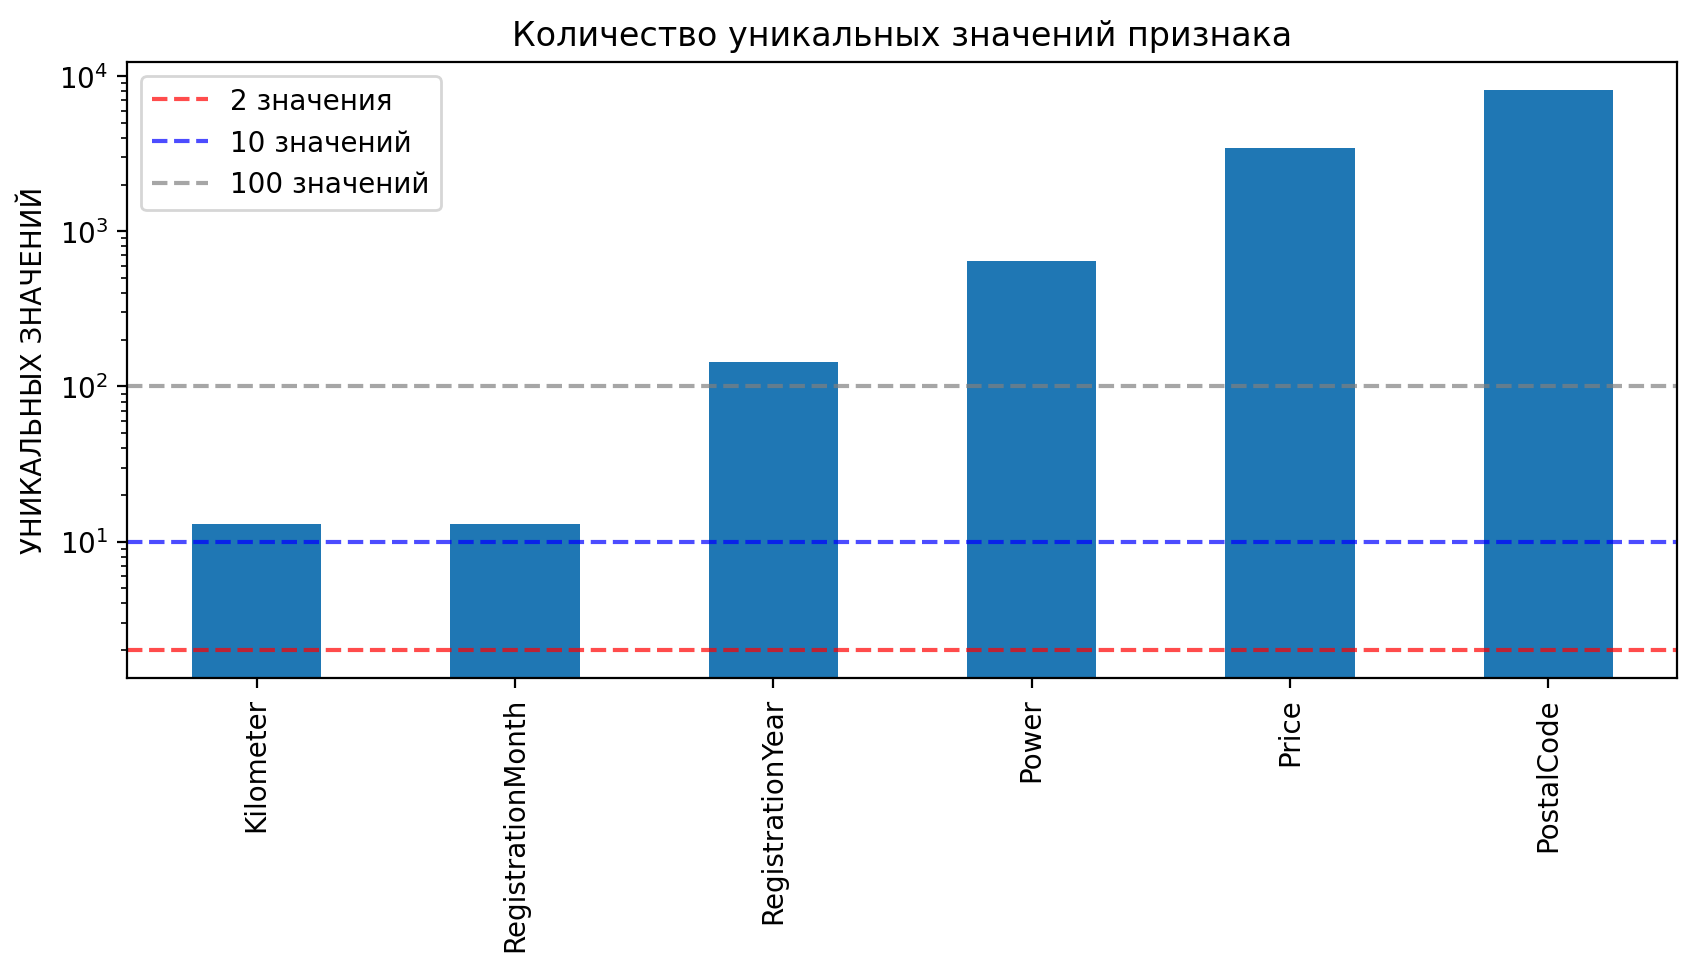

In [39]:
# для каждого числового столбца посчитаем количество уникальных значений и отсортируем
unique_values = df[numerical_columns].nunique().sort_values()

# Построим график с логарифимческой шкалой
unique_values.plot.bar(
    logy = True, figsize = (10, 4),
    title = 'Количество уникальных значений признака'
);

# добивим горизонтальные линии для значений 2 и 10, чтобы визуализировать бинарные и 
# дискретные признаки 
plt.axhline(2, color='red', alpha=0.7, linestyle='dashed')
plt.axhline(10, color='blue', alpha=0.7, linestyle='dashed')

# добавим линию сетки для значения 100
plt.axhline(100, color='gray', alpha=0.7, linestyle='dashed')

plt.ylabel('Уникальных значений'.upper())
plt.legend(['2 значения', '10 значений', '100 значений'])
plt.show()

Видим, что признак `Kilometer` имеет чуть больше 10 уникальных значений, то есть является дискретным. 

`RegistrationMonth` ожидаемо имеет 13 значений (12 месяцев и ноль).

Отметим, что количество уникальных значений для признака `RegistrationYear` намного больше ожидаемого из логики, что на продажу выставляются атомобили возрастом до нескольких дестятков лет.

Отметим, что можность двигателя представляена примерно 600-ми уникальных значений, а цена — 3-мя тысячами уникальных значений. 

Наибольшим разнообразием отличаются значения почтовых индексов.

##### Выводы

Мы выяснили, что наши данные представленны числовыми, категориальными и временными признаками.

Один признак содержит только нули и мы сразу можем исключить его из анализа. 

Среди остальных признаков мы ожидаем увидеть неявные пропуски и аномалии в значениях. 

#### Качество данных

На этом этапе оценим общее качество данных в датасете: дубликаты, пропуски, ошибки заполнения.

##### Дубликаты

In [40]:
duplicates_number = df.duplicated().sum()
print(f'Нашли {duplicates_number} дубликатов в датасете.')

Нашли 4293 дубликатов в датасете.


Дубликаты появлились после округления даты и времени загрузки объявления до дней. Видим, что некоторые объявляения были загружены несколько раз.

Дубликаты нам не нужны, удалим.

In [41]:
df = df.drop_duplicates().reset_index(drop = True)
df.shape

(279202, 16)

##### Пропуски

На этапе обзора структуры данных, мы видели пропуски в категориальных признаках, а также неявные пропуски в численных. 

Оценим долю пропущенных значений в датасете.

In [42]:
(df[datetime_columns + categorical_columns].isna().sum() /
 df.shape[0]).sort_values(ascending=True)

DateCrawled    0.000000
DateCreated    0.000000
LastSeen       0.000000
Brand          0.000000
Model          0.056300
Gearbox        0.056332
FuelType       0.093753
VehicleType    0.106529
NotRepaired    0.202345
dtype: float64

In [43]:
((df[numerical_columns] == 0).sum() / df.shape[0]).sort_values(ascending=True)

RegistrationYear     0.000000
Kilometer            0.000000
PostalCode           0.000000
Price                0.030533
RegistrationMonth    0.105845
Power                0.114082
dtype: float64

Мы видим пропуски в признаках `Model`, `Gearbox`, `FuelType`, `VehicleType`, `NotRepaired`, `Price`, `RegistrationMonth`, `Power`.

Самыми критичными являются пропуски целевого признака, но таких объектов только 3%.

Количество объектов с пропусками модели и типа трансмиссии 5,6%. 

Примерно у 10% объектов есть пропуски в типе топлива, типе кузова, месяце регистрации и мощности двигателя.

Больше всего пропусков признака `NotRepaired` — 20%. 

Оценим распределение пропусков по объектам.

In [44]:
nan_columns = ['Price', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'RegistrationMonth', 'Power']

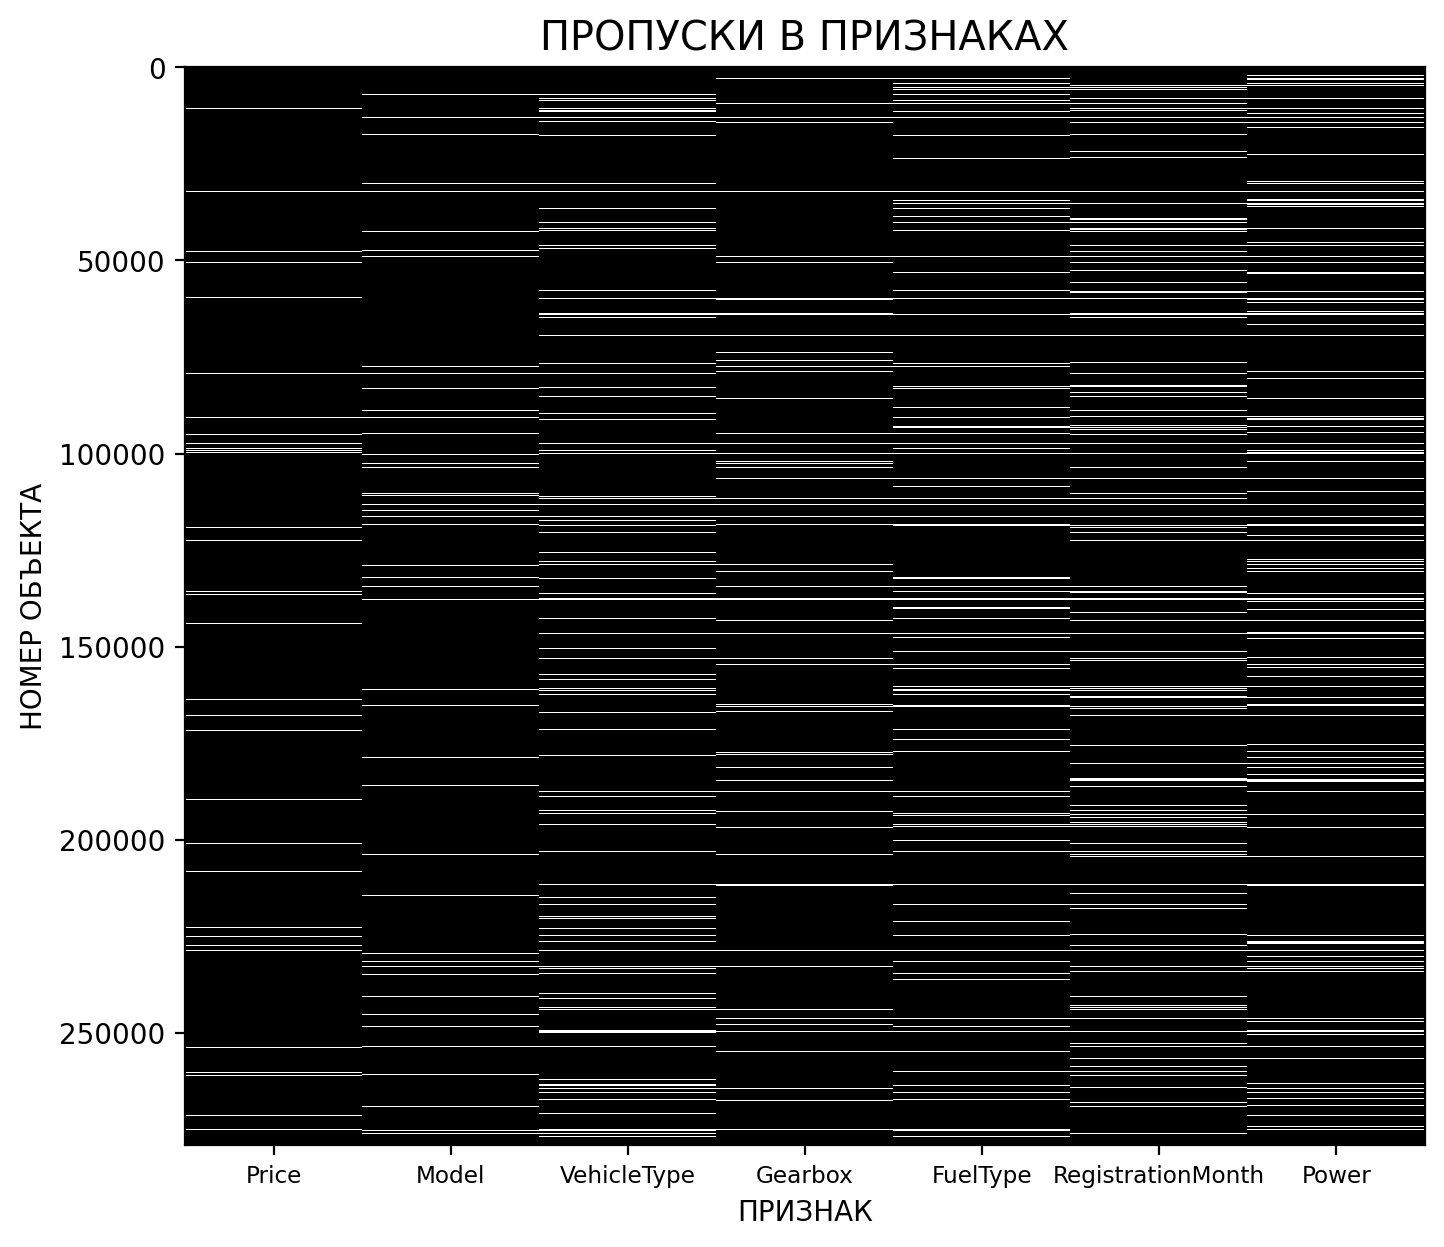

In [45]:
plt.figure(figsize=(8, 7))
plt.imshow((df[nan_columns].isna()) |
           (df[nan_columns] == 0),
           aspect='auto',
           interpolation='nearest',
           cmap='gray')
plt.xlabel('Признак'.upper())
plt.xticks(ticks=range(len(nan_columns)),
           labels=nan_columns,
           fontsize='small')
plt.ylabel('Номер объекта'.upper())
plt.title('Пропуски в признаках'.upper(), fontsize='x-large')
plt.show()

Видим, что пропуски распределены по датасету более-менее равномерно, без явных паттернов.

Есть объекты с пропусками в нескольких признаках, представленные горизонтальные прямыми. То есть в нашем датасете есть объекты, для которых известны только бренд автомобилия и пробег.

Также есть объеты с пропусками одного или нескольких признаков. Возможно, для таких объектов у нас получится заполнить пропуски на основании значений других признаков.

Пропуски целевого признака мы не можем заполнить, поэтому удалим объекты с пропусками. Заполнение пропусков в остальных признаках мы сделаем после анализа значений признаков.

In [46]:
df = df[df.Price > 0]
df.shape

(270677, 16)

##### Ошибки заполнения числовых признаков

Проверим наш датасет на проблемы с заполнением числовых значений. 

Для каждого числового признака построим график, который визуализирует значения признака (ось Y) для каждого из объектов в датасете (ось X).

Мы ожидаем, что распределение значений будет охватывать весь диапазон по оси Y для всех объектов, то есть на всем протяжении оси X. 

Пробелы по оси X покажут ошибки заполнения значений, а визуальные паттерны будут говорить о характере заполнения датасета.

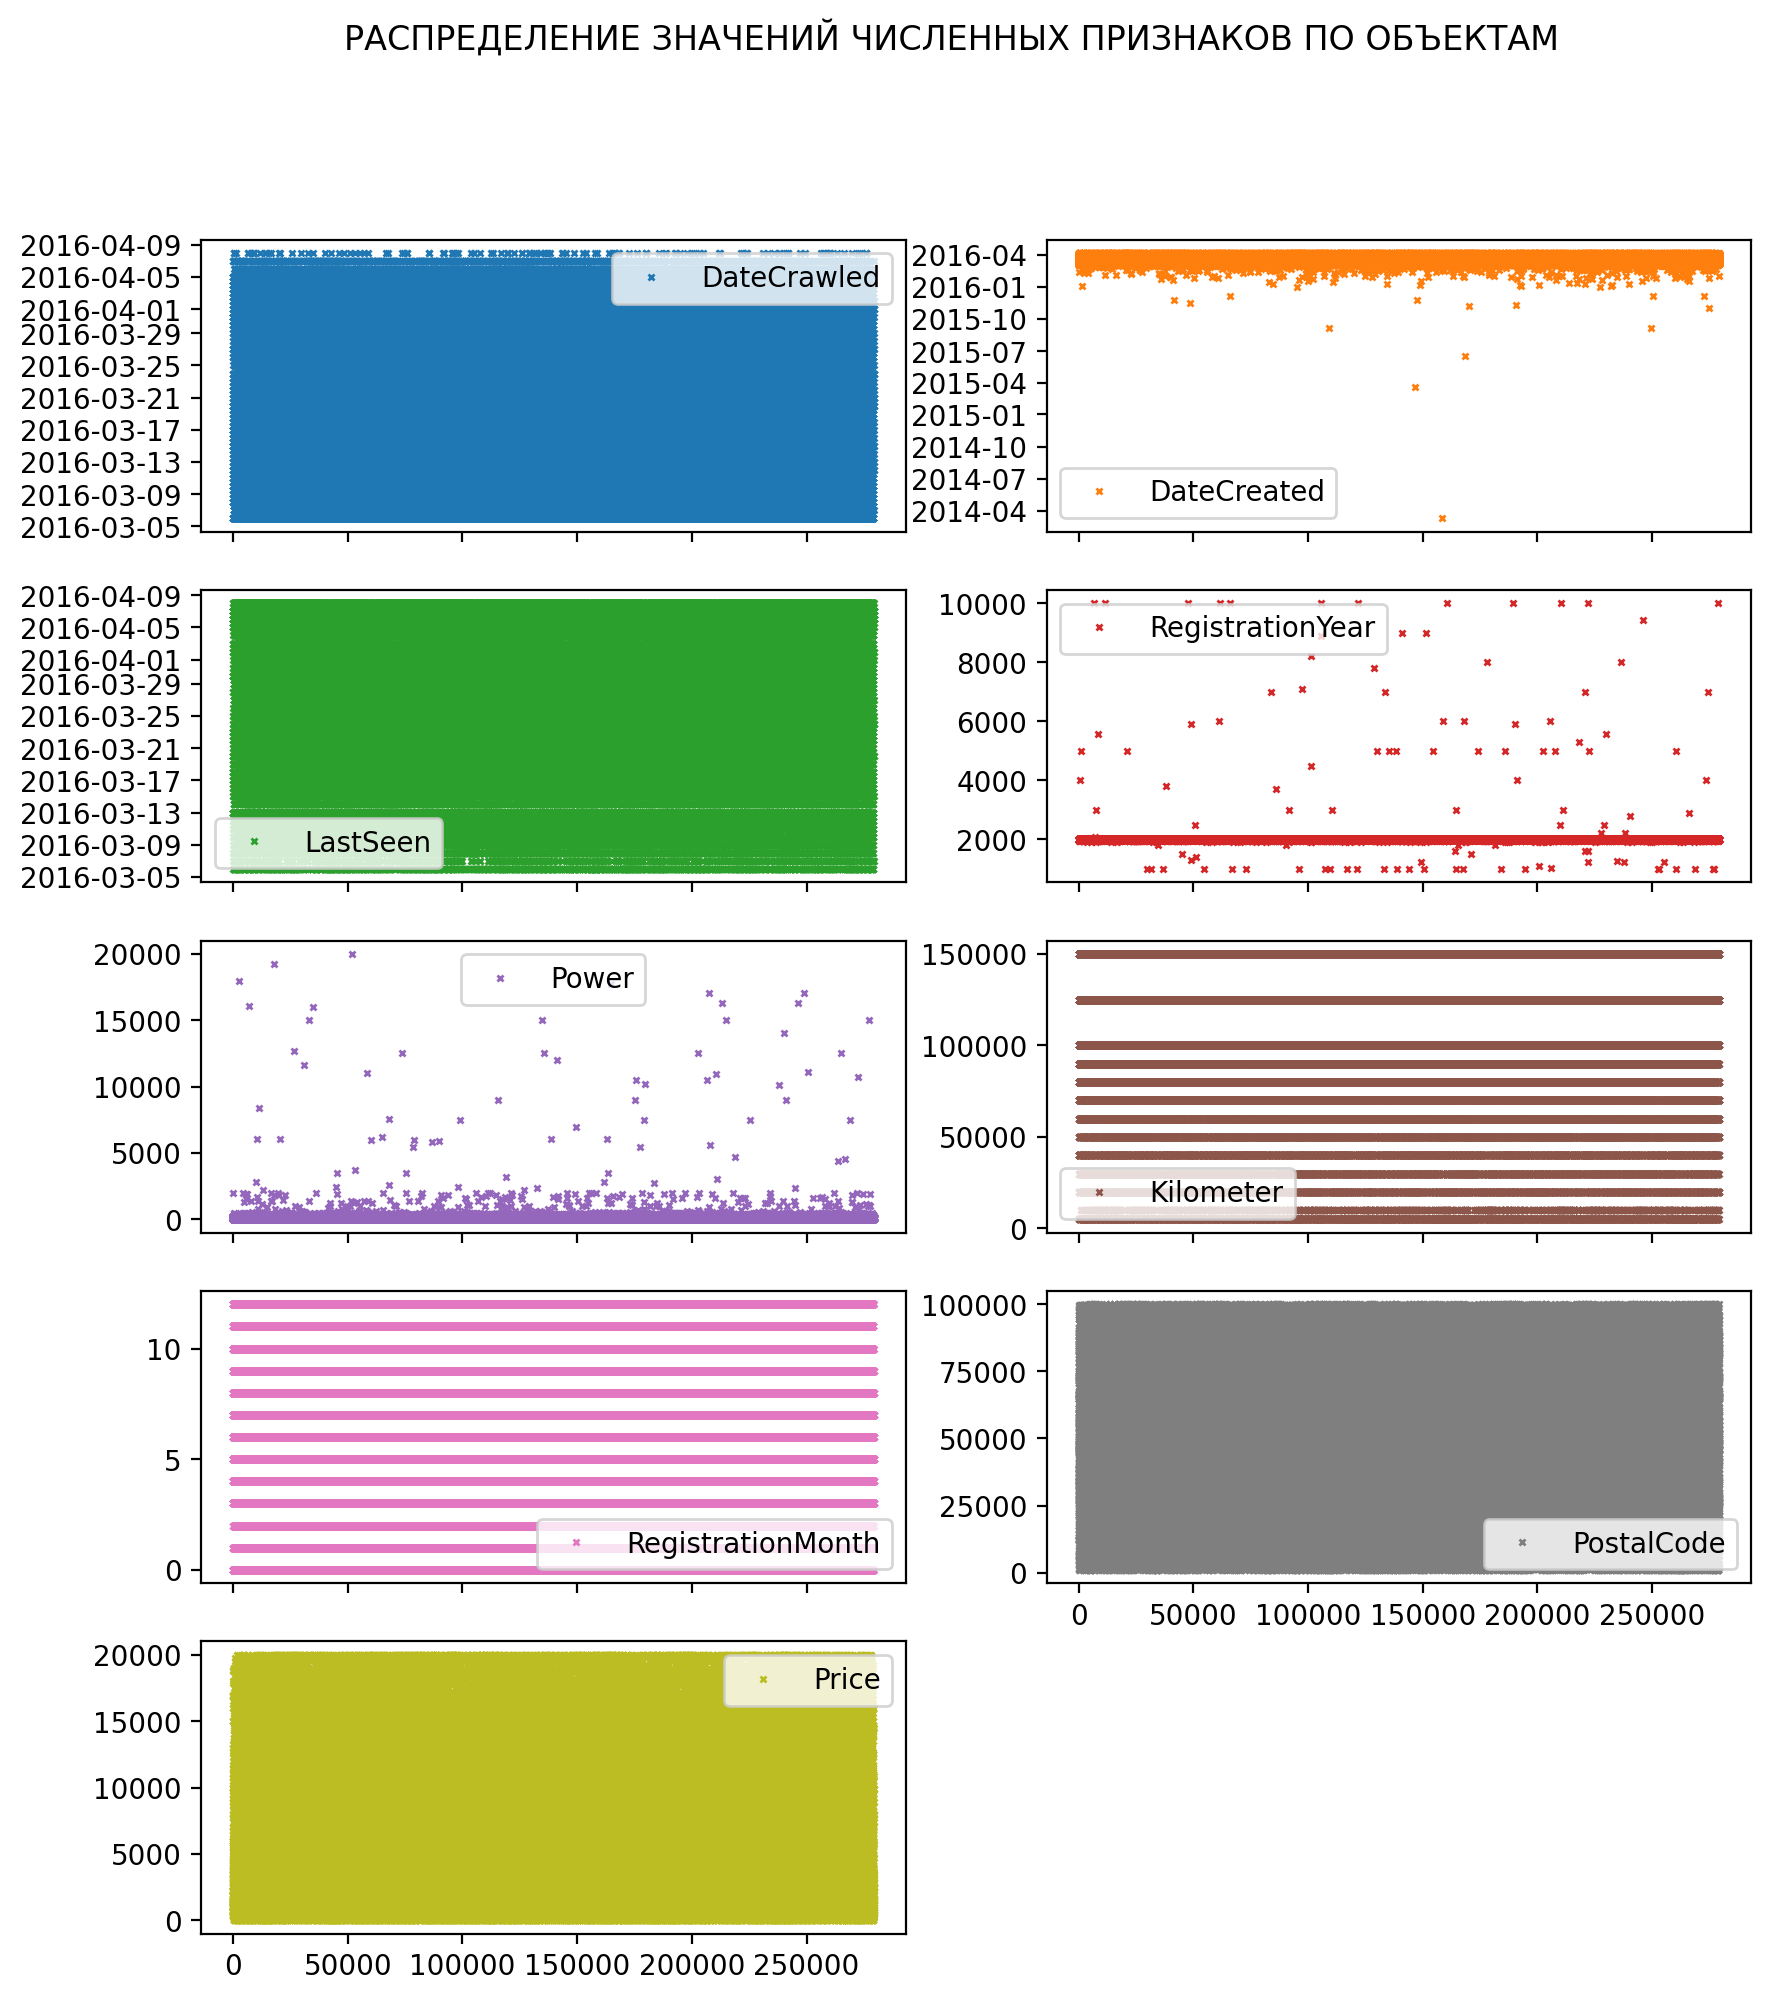

In [47]:
df[datetime_columns + numerical_columns].plot(
    lw=0, marker="x", subplots=True, layout=(-1, 2),
    figsize=(10, 11), markersize=2, 
    title = 'Распределение значений численных признаков по объектам'.upper()
);

plt.show()

Мы не видим ошибок и паттернов в нашем датаесете, значения парамтров раномерно распределены по всем объектам. 

Редкие нерпавдоподобные значения для `RegistrationYear` и `Power` встречаются равномерно, что говорит об ошибках в самих анкетах, а не в принципе их сбора. 

##### Выводы

Мы обнаружили в данных дубликаты и удалили их. 

Мы изучили явные и неявные пропуски в признаках. Объекты с пропущенными значениями целевого признака мы сразу исключили из дальнейшего анализа. Метод устрания пропусков мы сформулируем после проведения исследовательского анализа данных.

Ошибки и паттерны в датасете мы не обнаружили, что говорит о корректности сбора данных.

#### Анализ значений

##### Время

В нашем датасете есть три признака, описывающих время: дата загрузки анекты, дата создания анкеты и дата последнего просмотра анкеты.

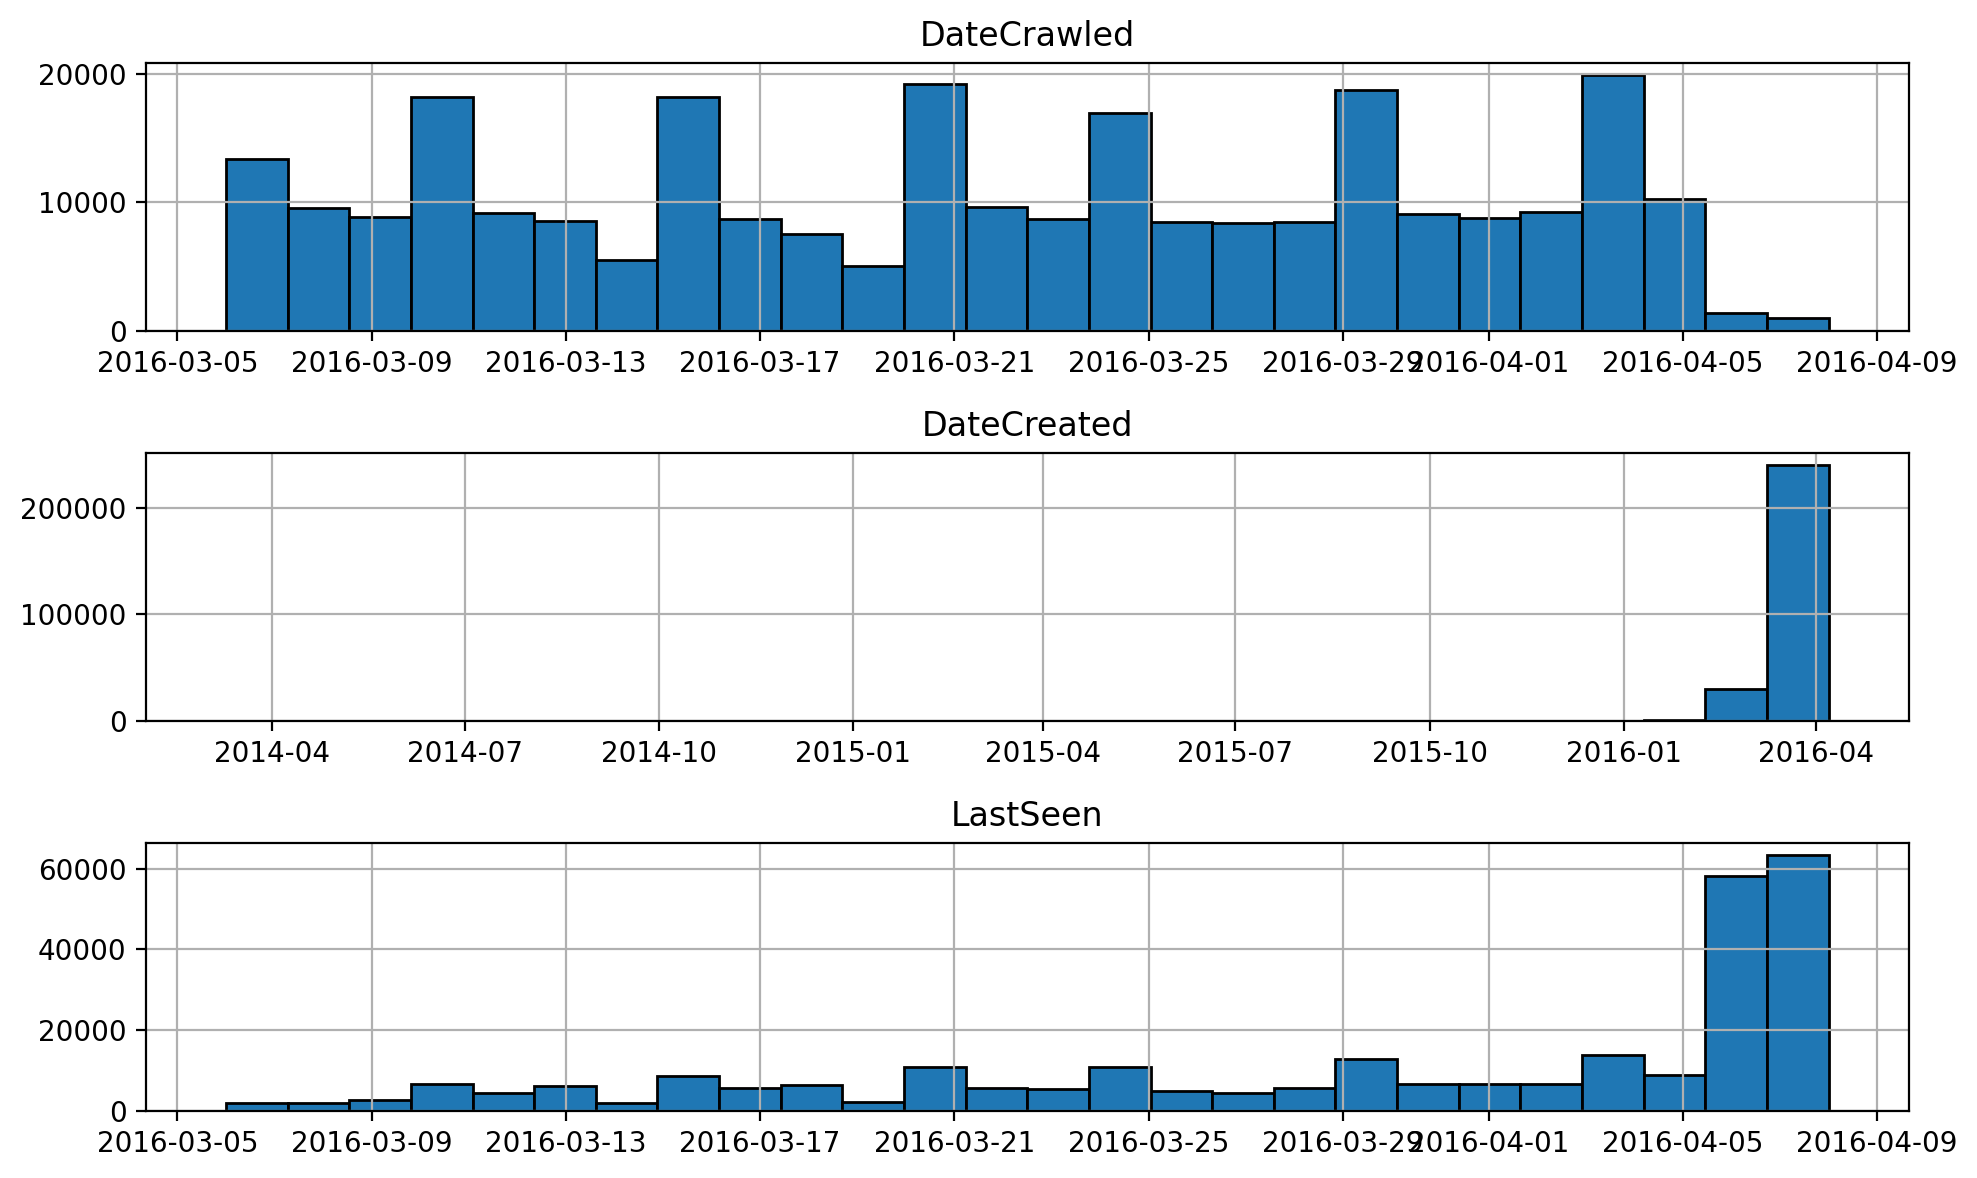

In [48]:
df[datetime_columns].hist(bins=26,
                           figsize=(10, 6),
                           layout=(-1, 1),
                           edgecolor="black")
plt.tight_layout()
plt.show()

Мы видим, что сбор анкет началася в марте 2016 года и закончился в апреле 2016 года, продолжался чуть более месяца.

Большинство собранных анкет было создано в марте-апреле 2016 года, что совпадает с датами сбора. То есть большинство анкет было собрано сразу после создания.

На этот же период выпадает и большинство просмотров анкет, что похоже на запуск сервиса в апреле 2016 года.

Рассчитаем и проанализируем возраст анкет в днях.

In [49]:
df['AnketaAge'] = (df.DateCrawled - df.DateCreated).astype('timedelta64[D]')

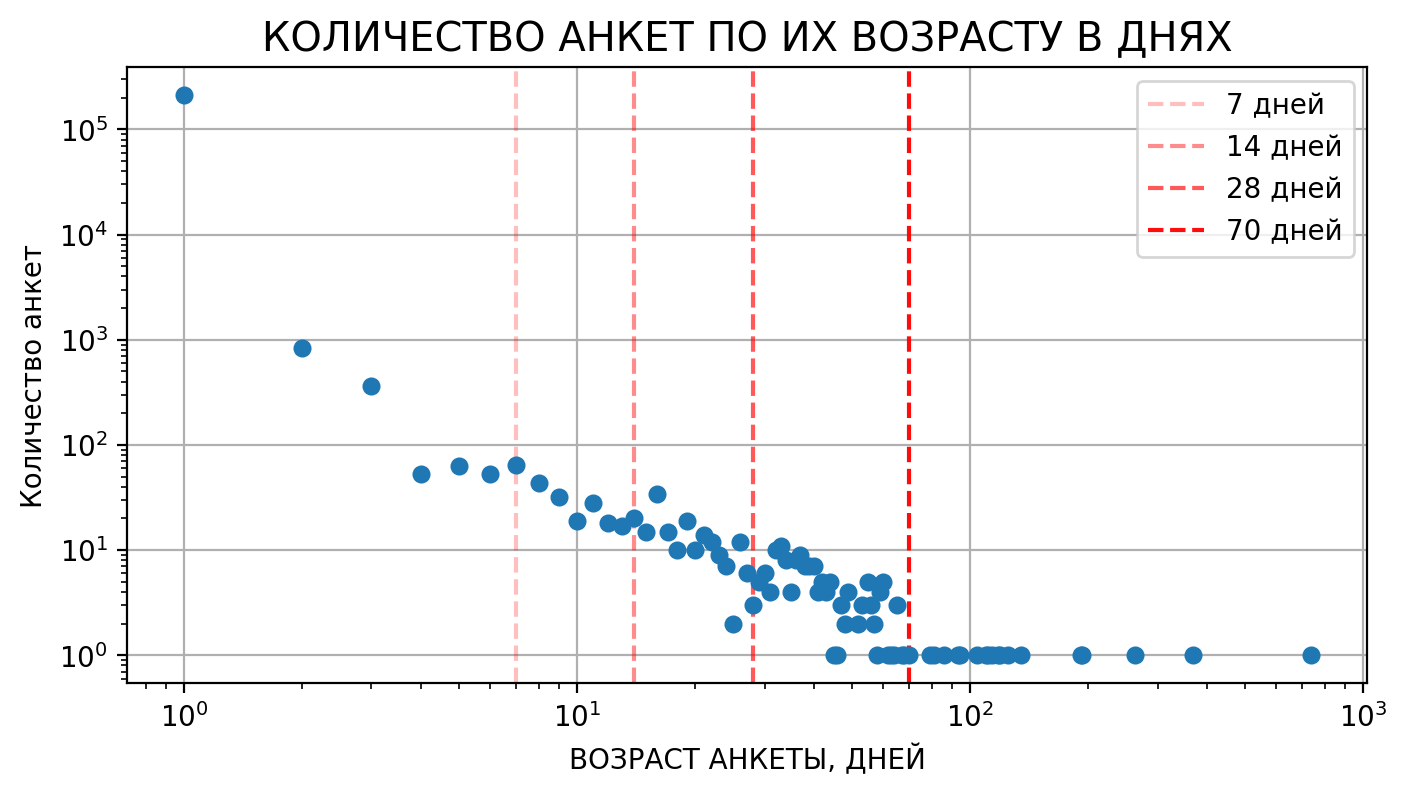

In [50]:
plt.axvline(7, c='r', alpha=.25, linestyle='dashed')
plt.axvline(14, c='r', alpha=.45, linestyle='dashed')
plt.axvline(28, c='r', alpha=.65, linestyle='dashed')
plt.axvline(70, c='r', alpha=.95, linestyle='dashed')

df.AnketaAge.value_counts(sort=False).sort_index().plot(lw=0,
                                                        marker='.',
                                                        markersize=11,
                                                        logy=True,
                                                        logx=True,
                                                        figsize=(8, 4),
                                                        grid=True)

plt.title('Количество анкет по их возрасту в днях'.upper(), fontsize='x-large')
plt.xlabel('Возраст анкеты, дней'.upper())
plt.ylabel('Количество анкет')
plt.legend(['7 дней', '14 дней', '28 дней', '70 дней'])
plt.show()

Мы видим, что 200 тысяч акет имеют возраст 1 день, далее до 70 дней мы видим быстро уменьшающееся количество анкет с увеличеним возраста, и в конце несколько десятков анкет с возрастом более 70 дней.

В целом наш датасет содрежит актуальные акеты. Подозрительно выглядит только анкета с возрастом больше года. Посмотрим на нее.

In [51]:
df[df.AnketaAge > 365].T

,146707,158311
DateCrawled,2016-03-24 00:00:00,2016-03-16 00:00:00
VehicleType,bus,NaN
RegistrationYear,1995,2005
Gearbox,auto,NaN
Power,200,0
Model,other,147
Kilometer,150000,125000
RegistrationMonth,0,0
FuelType,petrol,petrol
Brand,chevrolet,alfa_romeo


Не видим ничего криминального.

Признак `LastSeen` не имеет отношение к анализируемым объектам, в дальнейшем его рассматривать не будем. 

Признак `DateCreated` позволит нам посчитать возраст автомобиля на следующем шаге.

##### Числовые признаки

Построим гистограммы и бокс-плоты для числовых признаков.

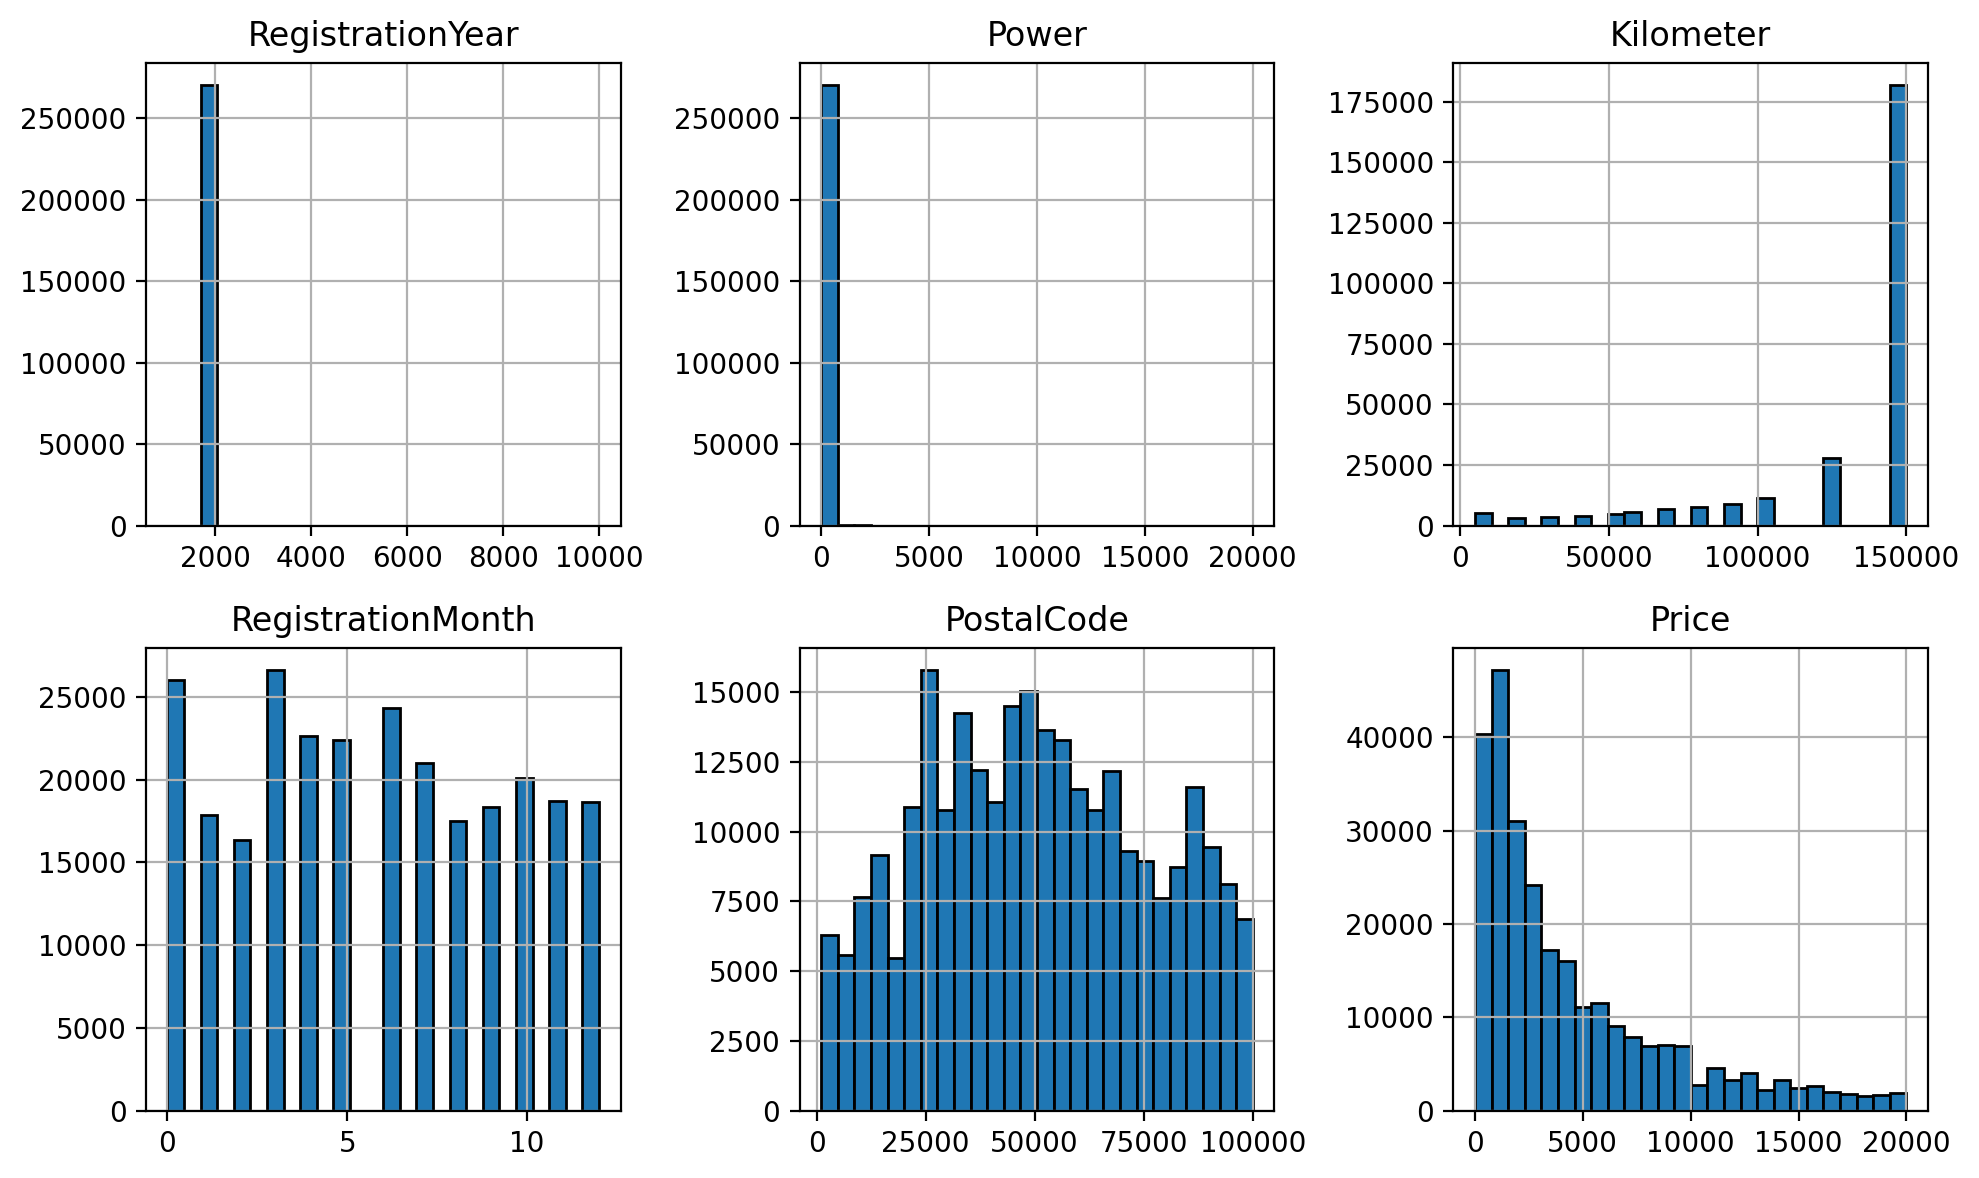

In [52]:
df[numerical_columns].hist(bins=26,
                           figsize=(10, 6),
                           layout=(-1, 3),
                           edgecolor="black")
plt.tight_layout()
plt.show()

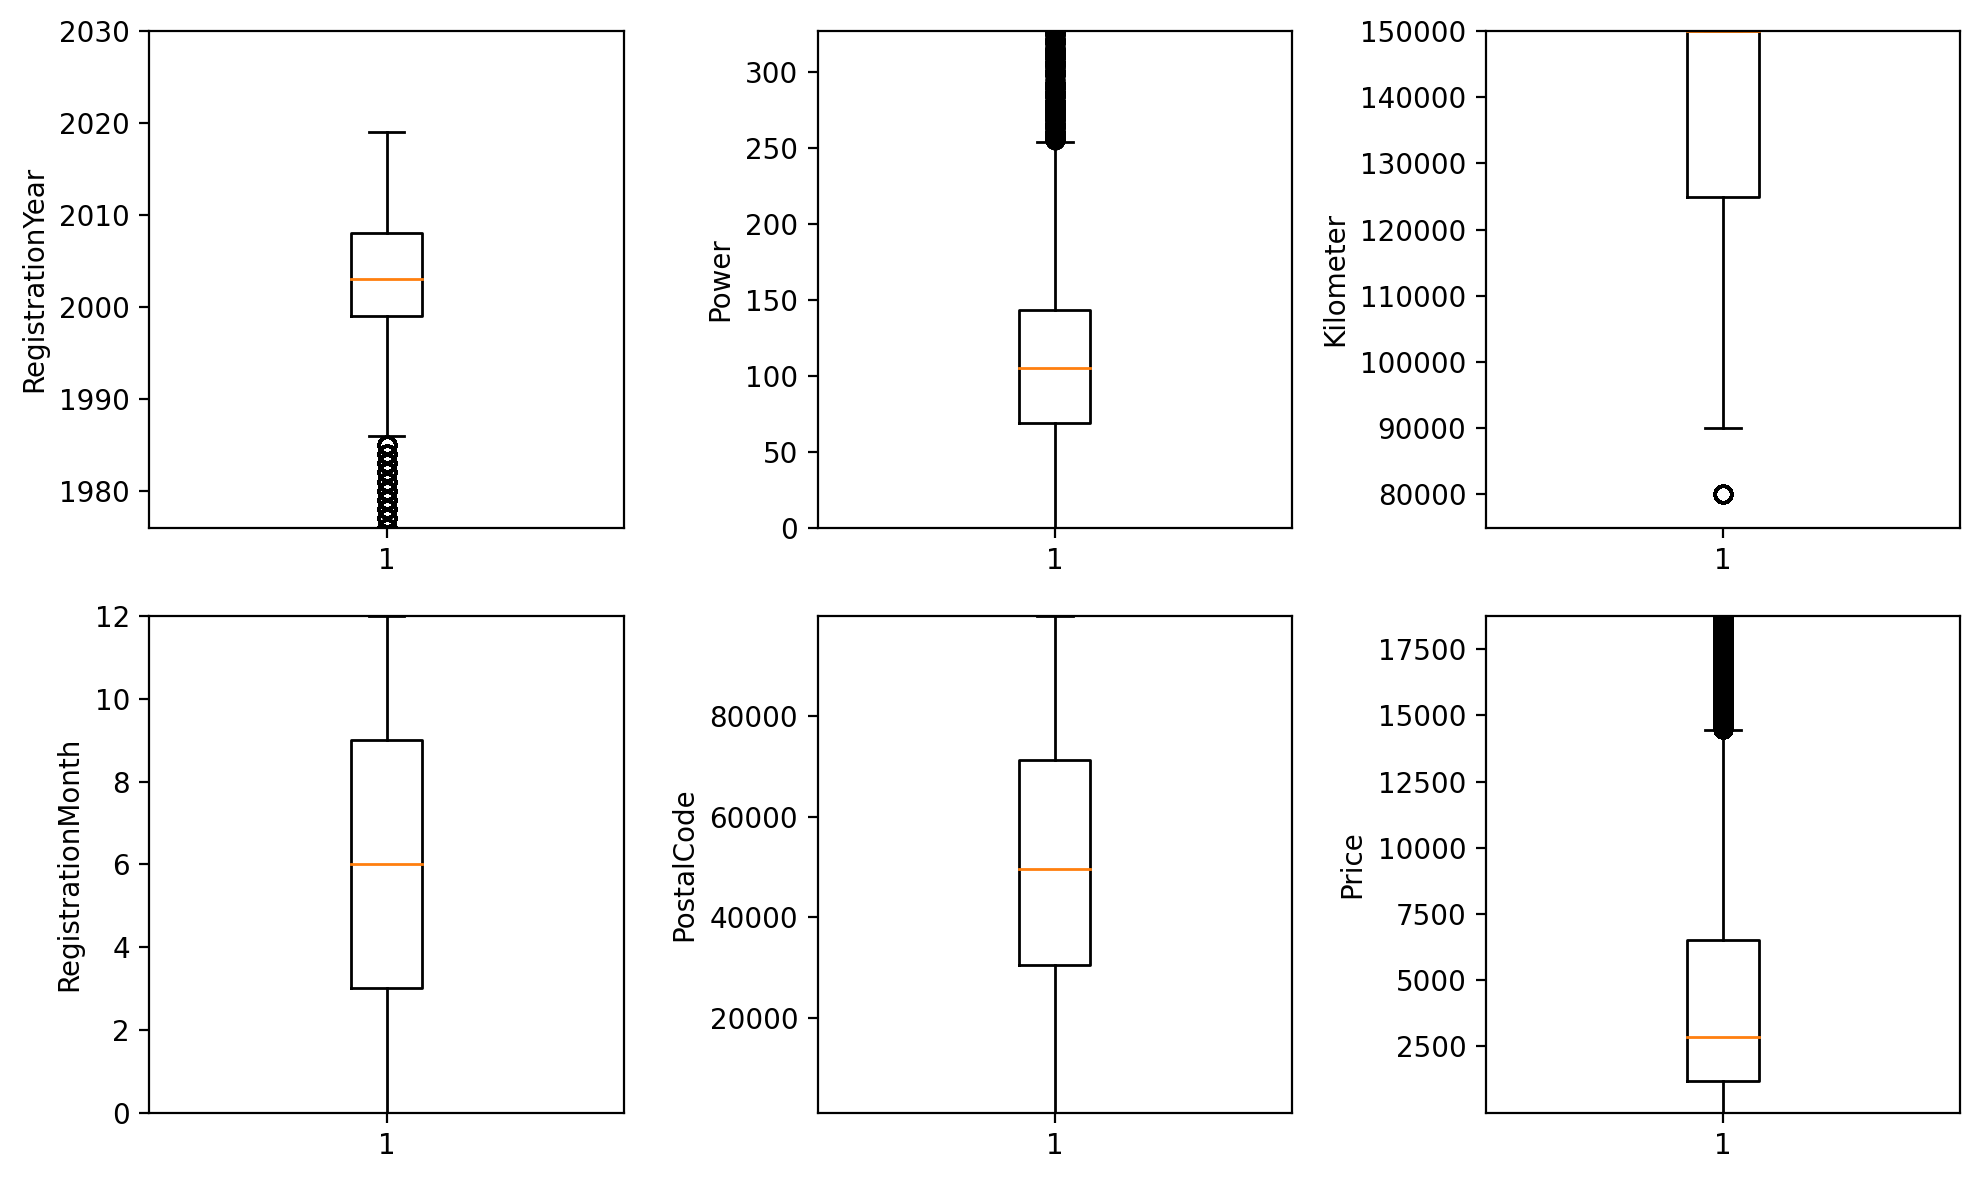

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

def draw_boxplot(ax, x, column_name, ylabel):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    median = x.median()
    data_range = (
        max(x.min(), median-3*iqr),
        min(x.max(), median+3*iqr)
    )
    ax.boxplot(x=x)
    ax.set_ylim(data_range)
    ax.set(ylabel=column)
    
for column, ax in zip(numerical_columns, axes.ravel()):
    draw_boxplot(ax, df[column], column, 'label')
plt.tight_layout()
plt.show()

Распределение цены похоже на логнормальное, для которого нормальным является длинный хвост значений. Аномалий в значениях мы не наблюдаем.

У пробега распределение тоже похоже на логнормальное, но умноженное на -1 и смещенное на 150000. Аномалий в значениях мы не наблюдаем.

Также не видим аномалий в распределении значений `RegistraionMonth` и `PostalCode`. 

Только `RegistrationYear` и `Power` имеют выборосы с большим диапазоном значений. Проанализируем эти признаки. 

**ГОД РЕГИСТРАЦИИ АВТОМОБИЛИЯ**

Перейдем от признаков `RegistrationYear` и `RegistrationMonth` к признаку возраст автомобиля `CarAge` на дату публикации объявления в целом количестве лет. При этом пренебрежем ошибкой в 1 месяц, которая будет возникать для объектов с `RegistrationMonth`, равным нулю.

In [54]:
df['CarAge'] = round(
    (df.DateCreated.dt.year * 12 + df.DateCreated.dt.month -
     df.RegistrationYear * 12 - df.RegistrationMonth) / 12).astype('int')
df[['RegistrationYear', 'RegistrationMonth', 'DateCreated', 'CarAge']].head()

,RegistrationYear,RegistrationMonth,DateCreated,CarAge
0,2010,12,2016-03-14,5
1,2011,6,2016-03-18,5
2,2004,10,2016-03-28,11
3,2004,4,2016-03-28,12
4,2000,4,2016-03-30,16


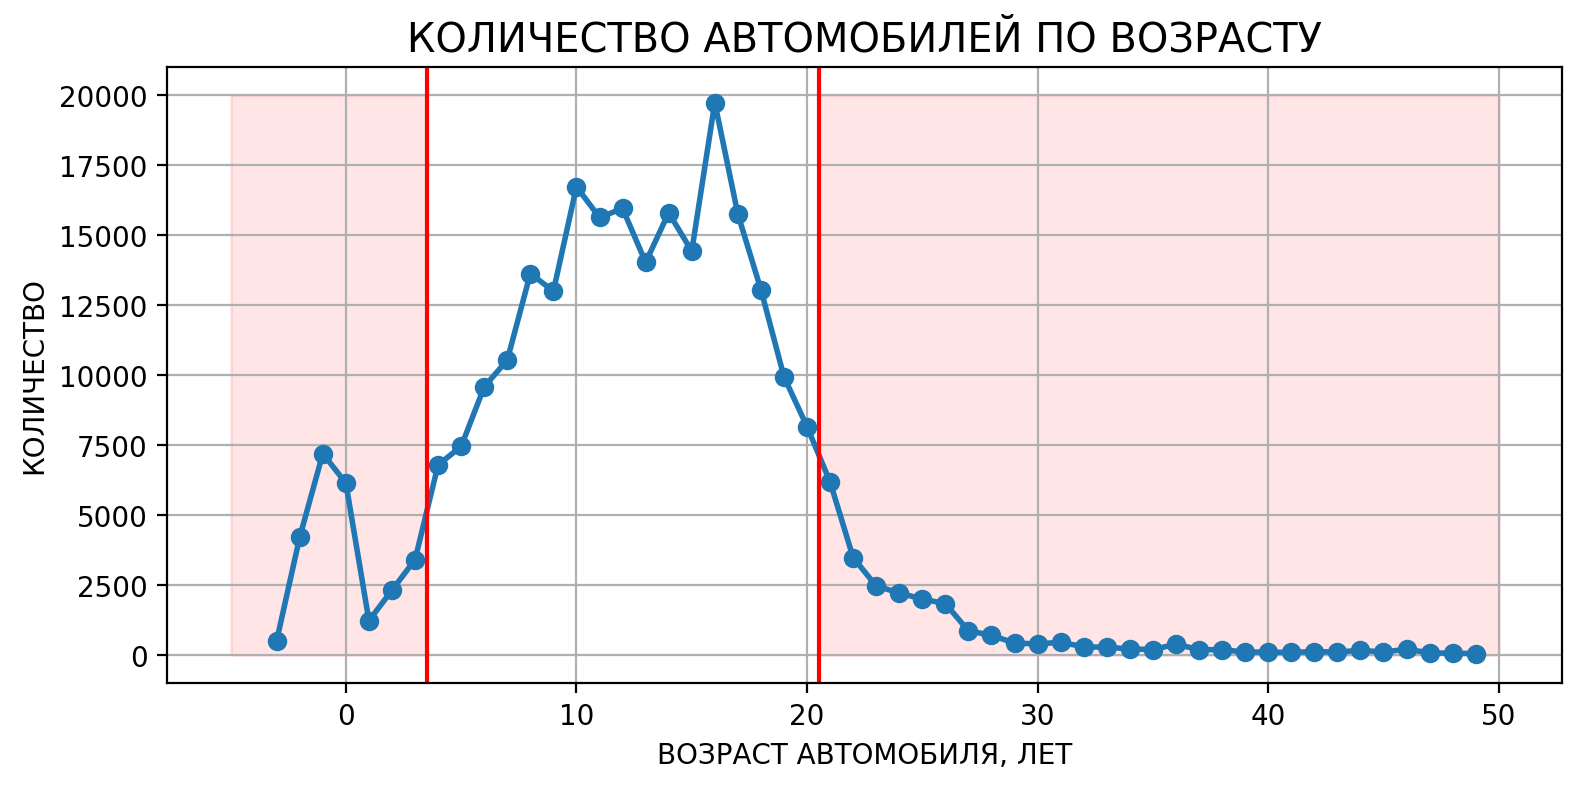

In [55]:
df.loc[(df.CarAge > -5) & (df.CarAge < 50),
       ['CarAge', 'Price']].groupby(['CarAge']).count().plot(lw=2,
                                                             marker='o',
                                                             figsize=(9, 4),
                                                             grid=True,
                                                             legend=None)
plt.axvline(3.5, c='r')
plt.axvline(20.5, c='r')
plt.fill_between([-5, 3.5], 20000, color='r', alpha=.1)
plt.fill_between([20.5, 50], 20000, color='r', alpha=.1)
plt.title('Количество автомобилей по возрасту'.upper(), fontsize='x-large')
plt.ylabel('Количество'.upper())
plt.xlabel('Возраст автомобиля, лет'.upper())
plt.show()

Большинство объявлений имеет возраст от 4 до 20 лет. 

Посмотрим, как изменяется цена в зависимости от возраста автомобилия. Обратим внимание как на объявления, в которых год регистрации автомобилей больше года создания объявления, то есть в будущем, так и на старые автомобили.

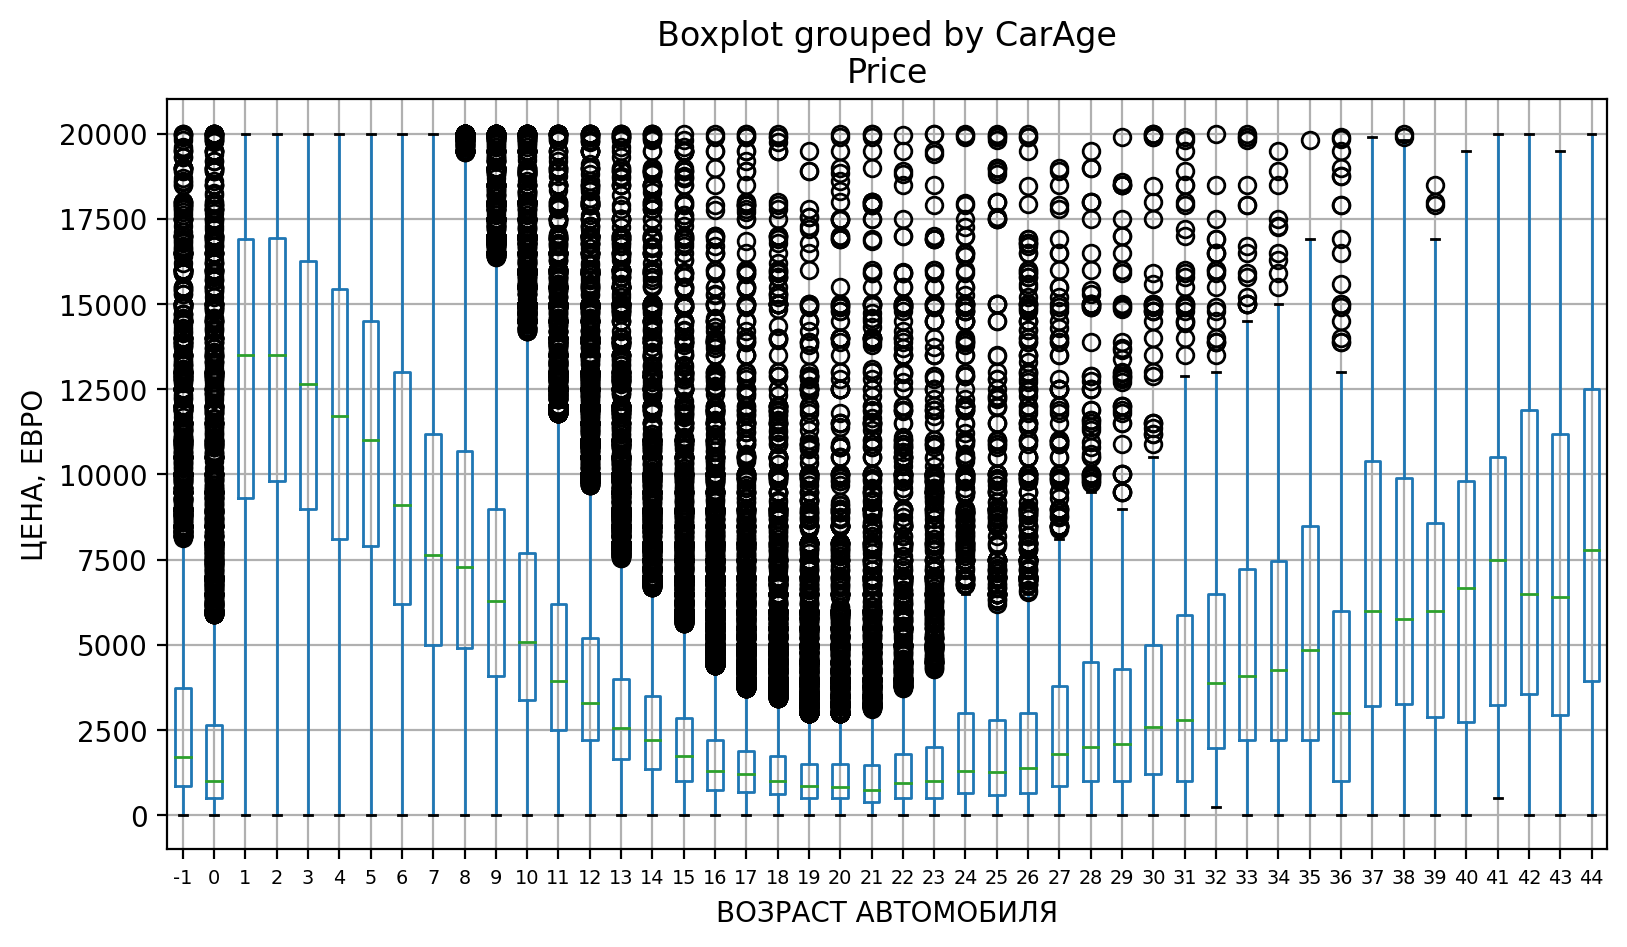

In [56]:
df.loc[(df.CarAge > -2) & (df.CarAge < 45),
       ['CarAge', 'Price']].boxplot(column='Price',
                                    by='CarAge',
                                    figsize=(9, 5))
plt.xlabel('Возраст автомобиля'.upper())
plt.xticks(fontsize='x-small')
plt.ylabel('Цена, евро'.upper())
plt.show()

Здесь мы видим, что для возраста 0 и -1 цена намного меньше, чем для возраста 1, 2 года. Значит мы не можем сказать, что 0 — это новый автомобиль. 

Межквартильное расстояние с ростом возраста автомобиля уменьшается, что говорит об уменьшении разброса цен. Отклонения встрачаются редки и мы видим их за пределами усов боксплота. Наименьшее межквартильное расстояние мы видим для возраста 19–21 год. Потом разброс цены снова растет. 

Согласно [American Collectors Community](https://americancollectors.com/articles/vintage-vs-classic-vs-antique-cars/) автомобили возрастом страше 20 лет относятся к классу ClassicCars, а старше 45 лет относятся к классу Antique Car. 

Ограничим область применения нашей модели возрастом от 4 до 20 лет включительно. До 4 лет у нас мало объявлений и большой разброс цен. Автомобили страше 20 лет относятся к специфической категории. Для этих автомобилей нужно разработать другую модель, если прогнозирование стоимости классических и антикварных машин нужно бизнесу.

**МОЩНОСТЬ**

В данных мы видим редкие неправдоподобные значения мощности автомобилией. Учитывая, что 
- мощность двигателей соврменных топовых коммерческих авто до 500лс ([источник hotcars.com](https://www.hotcars.com/most-powerful-engines-ever-fitted-production-cars/)), 
- наш сервис ориентирован на массовый сегмент, поэтому спорткары с мощностью до 1700 лс не рассматриваем,
- на боксплоте мы видим, что значения более 250 лс уже находятся в зоне вылетов,

Ограничим область применения нашей модели мощностью от 50 до 250 лс. 

Поскольку мощность является важным параметром автомобиля, пропущенные значения заполним средними значениями для бренда и модели автомобиля. Те объявления, где среднее значение расчитать не удасться, удалим.

**ЦЕНА**

Посмотрим, как в нашем датасете растет цена по объектам: упорядочим все объекты по росту цены и построим график цены от номера объекта. 

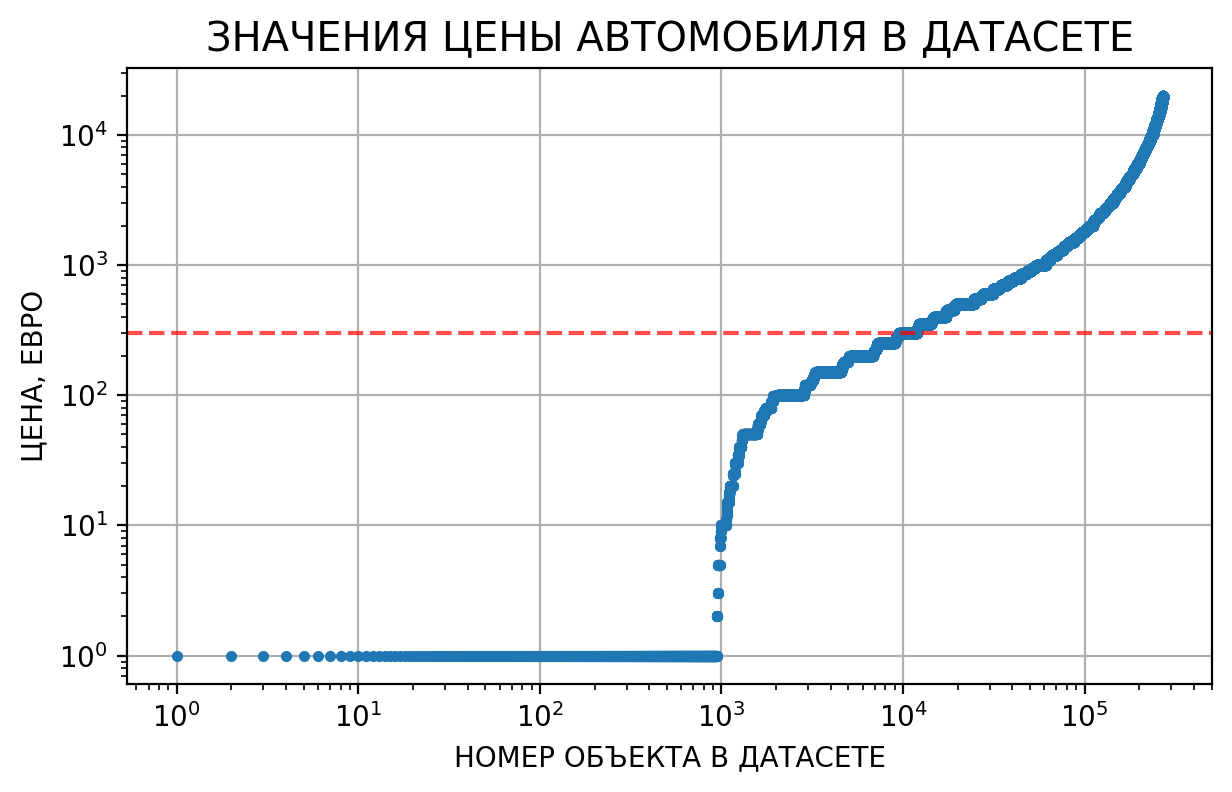

In [57]:
fig = plt.figure(figsize=(7, 4))
plt.plot(range(df.shape[0]),
         df.Price.sort_values(),
         marker='o',
         lw=0,
         ms=3)
plt.axhline(300, color='red', alpha=0.7, linestyle='dashed')
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.title('Значения цены автомобиля в датасете'.upper(), fontsize='x-large')
plt.ylabel('Цена, евро'.upper())
plt.xlabel('Номер объекта в датасете'.upper())
plt.show()

Мы видим, что в датасете есть 1000 объектов с ценой 1 евро и еще 1000 с ценой меньше 100 евро. 10 000 объявлений имеют стоимость меньше 300 евро. Выглядит очень странно при том, чтосредняя [цена на 10-летний автомобиль](https://www.statista.com/statistics/589613/average-prices-for-used-cars-germany/#statisticContainer) в Германии около 7000 евро. 

Однако на сайте [autoscout24.de](https://www.autoscout24.com/lst?sort=price&desc=0&atype=C&ustate=N%2CU&powertype=kw&priceto=500&search_id=vslwgpr1pq) действительно есть 1000 объявлений с ценой 1 евро, которые не выглядят как рыночная цена автомобиля.

Ограничим область применения нашей модели минимальной ценой 300 евро.

##### Категориальные признаки

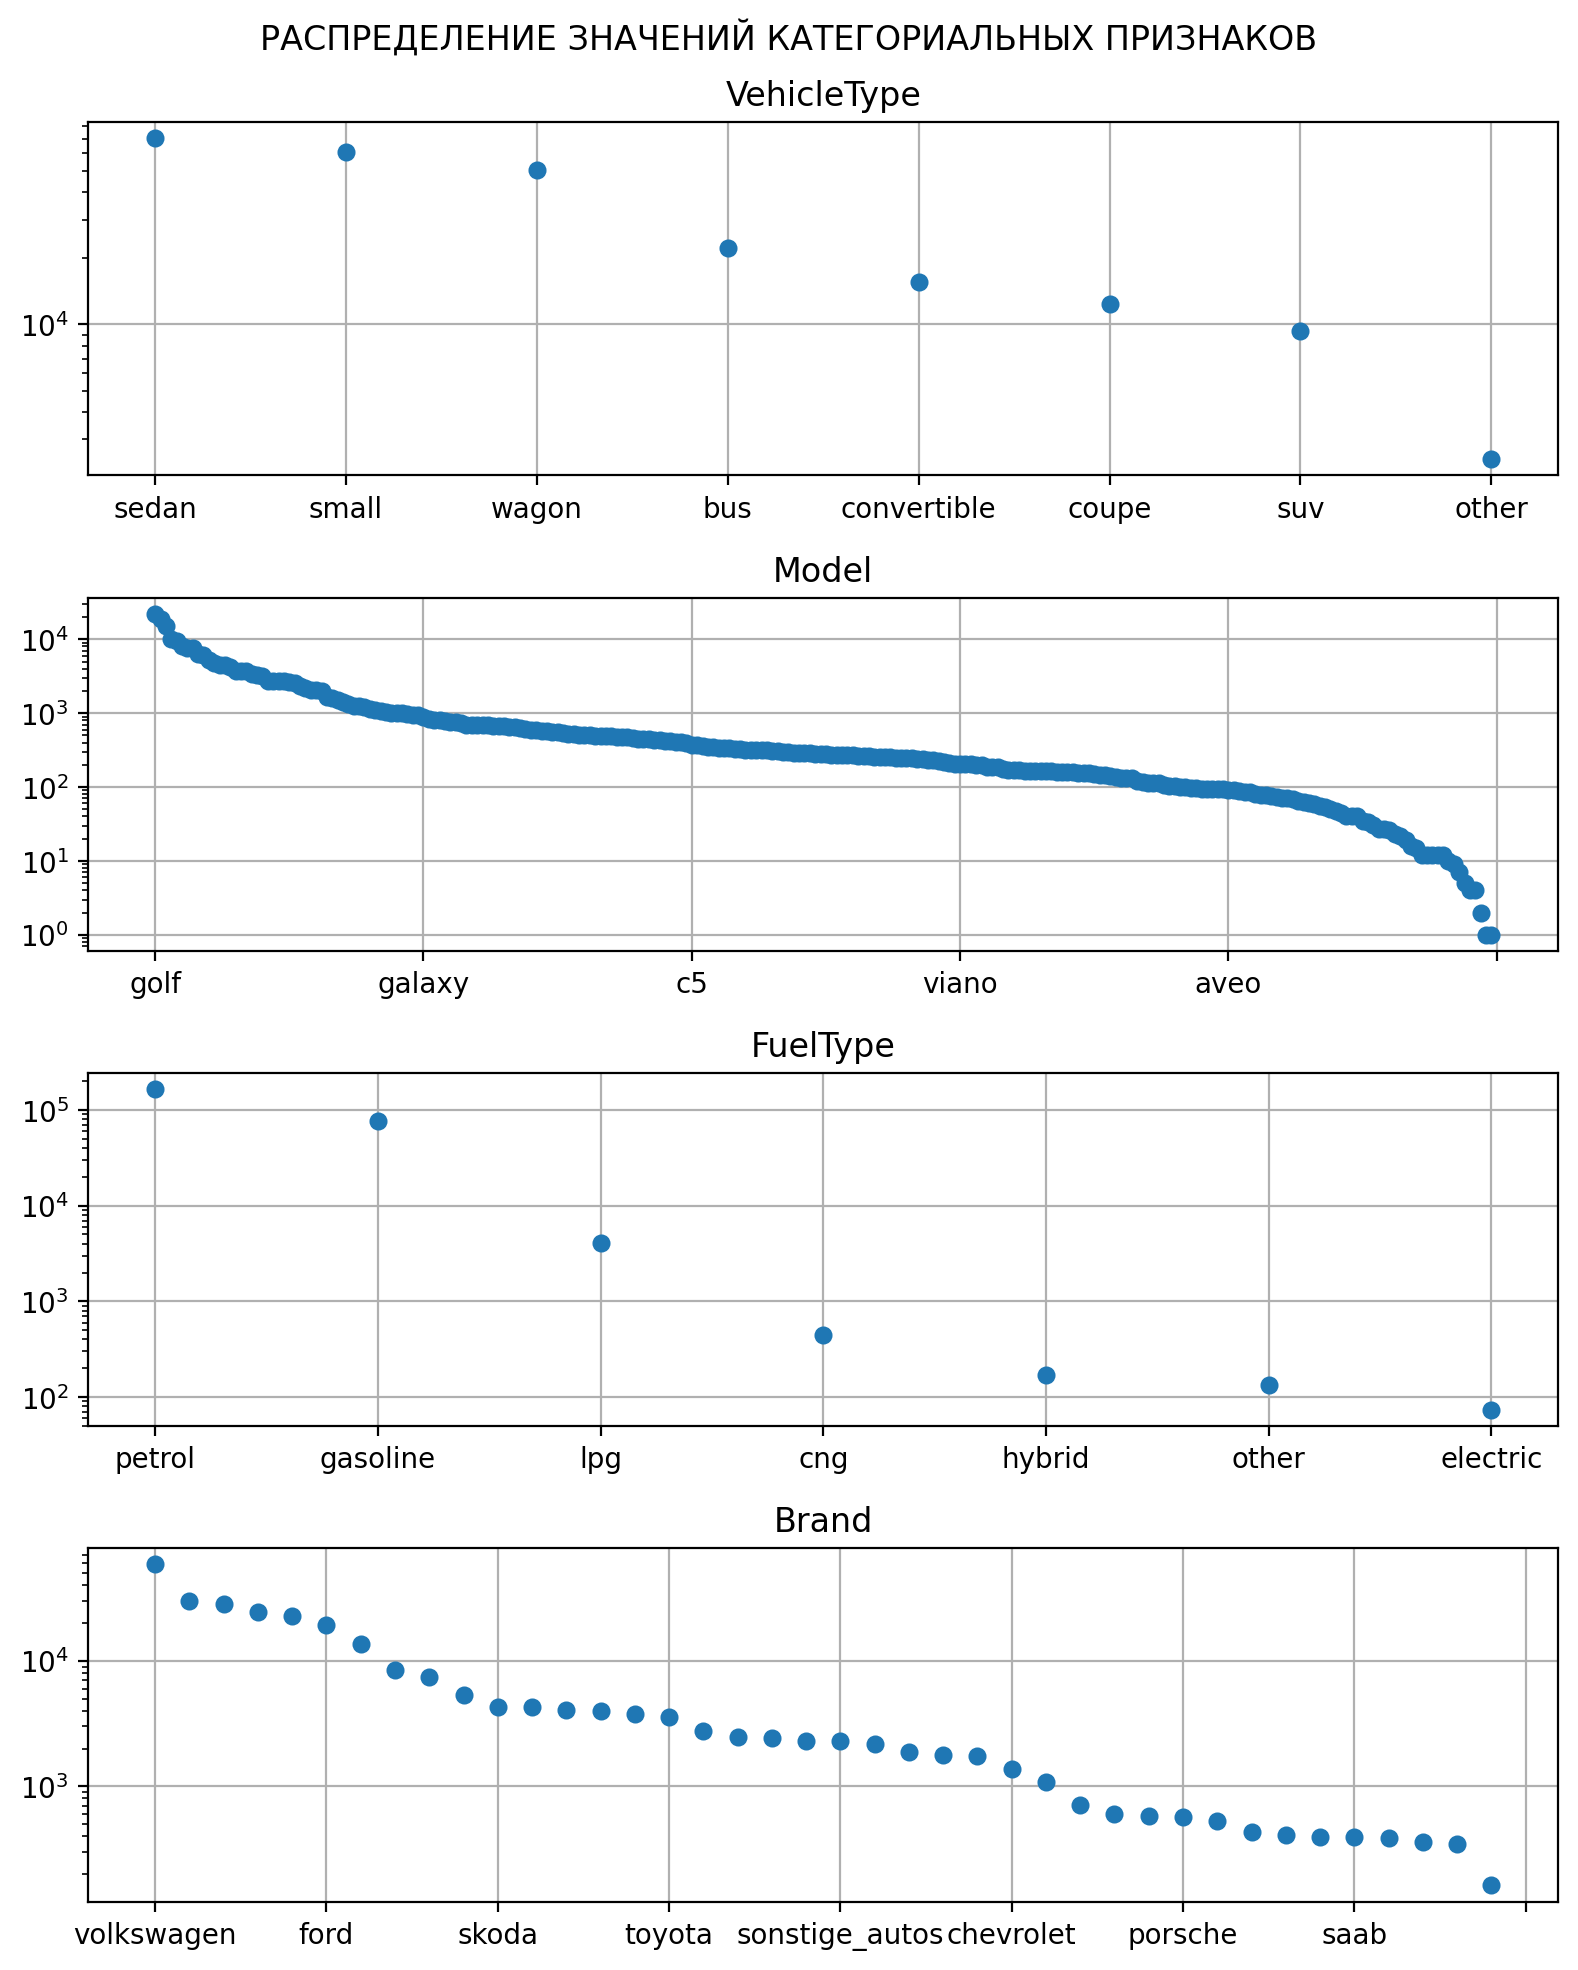

In [58]:
columns = [_ for _ in categorical_columns if _ not in ['Gearbox', 'NotRepaired']]

# Создадим фигуру с количеством графиков, равных количеству столбцов
fig, axes = plt.subplots(ncols=1,
                         nrows=len(columns),
                         figsize=(8, 10))

# Добавим в цикле график для каждого признака на соответсвующей оси
for col, ax in zip(columns, axes.ravel()):

    # Посчитаем количество уникальных значений признака
    df[col].value_counts().plot(

        # Отобразим на графике в логарифмической шкале
        logy=True,
        title=col,
        lw=0,
        marker='.',
        ax=ax,
        markersize=11,
        grid=True)

plt.suptitle('Распределение значений категориальных признаков'.upper())
plt.tight_layout()
plt.show()

Отметим, что на сайте [autoscout24.de](https://www.autoscout24.de/) мы видим и большое количество объявлений со старыми автомобилями и ценой в несколько сот евро, которые в действительностости представляют собой объявления о запчастях: [детали кузова](https://www.autoscout24.com/offers/studebaker-others-gasoline-silver-d7ca786c-8975-4c3e-9e1d-b5356d06f897?sort=price&desc=0&lastSeenGuidPresent=false&cldtidx=14&position=14&search_id=1ccky7t01lx&source_otp=t10&source=listpage_search-results), [мотор](https://www.autoscout24.com/offers/bmw-2002-motore-gasoline-grey-19ac5d4a-d439-4f56-9196-39d23b2971d2?sort=price&desc=0&lastSeenGuidPresent=false&cldtidx=42&position=42&search_id=1ccky7t01lx&source_otp=t10&source=listpage_search-results), [старый кузов с деталями](https://www.autoscout24.com/offers/fiat-500-gasoline-blue-6b609281-ae3a-4b58-8a55-2be781c0abb7?sort=price&desc=0&lastSeenGuidPresent=false&cldtidx=11&position=11&search_id=1ccky7t01lx&source_otp=t10&source=listpage_search-results).

В таких объявлениях с "запчастями" на [autoscout24.de](https://www.autoscout24.de/) не заполнены признаки, пропуски в которых мы наблюдали и в нашем датасете: тип кузова, тип коробки передач. Таким образом пропуски могут говорить о том, что объявление описывает не полноценный автомобиль.

**ТИП КУЗОВА**

Среди значений не видим аномалий. Намиеньшее количество объектов имеет значение other. 

Поскольку тип кузова является важной характеристикой автомобиля и не однозначно определяется моделью, пропуски значений этого признака являются критичными для обучения. Примем, что пропуск значения говорит о том, что объявление не относится к автомобилю, а описывает зап. часть. 

Для работы нашей модели указание типа кузова будет являться обязательным условием. При этом значение `other` сохраним на случай, если тип кузова будет отличаться от доступного списка значний, например "лимузин".

**МОДЕЛЬ**

Характер графика количества объектов по моделям соответствует ожиданиям. Отметим небольшое количество моделей в самой правой части, для которых меньше 10 объявлений.

Визуально проверим значения на неявные дубли.

In [59]:
df.Model.sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Неявных дублей в значениях не видим. Формат названий един для всех моделей.

Модель автомобиля также критична для определения стоимости. Поступим с пропусками по аналогии с типом кузова: пропущенное значение будем трактовать как объявление, не относящееся к автомобилю. Удалим такие объекты.

Для работы модели обязательно должна быть указана модель автомобиля.

**ТИП ТОПЛИВА**

Отметим, что два самых распространных значения типа топлива в данных petrol и gasoline — это [одно и тоже](https://en.wikipedia.org/wiki/Gasoline). На [autoscout24.com](https://www.autoscout24.com/refinesearch?sort=standard&desc=0&ustate=N,U&atype=C) в фильтре видим только gasoline.

Електромобилей в 2016 году еще практически нет.

Учитывая подавляющее большинство автомобилей с бензиновым топливом, признак не выглядит как критичный. Заполним пропуски значением `unknown`.

**БРЕНД**

Как и для модели, характер графика количества объектов по брендам соответствует ожиданиям. 

Проверим значения на неявные дубли.

In [60]:
df.Brand.sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Со значениями все в порядке. Отметим, что значение 'sonstige_autos' с немецкого переводится как 'other'.

Посмотрим, насколько уникальны модели по брендам.

In [61]:
(df[['Model', 'Brand']]
 .drop_duplicates()
 .groupby(by=['Model'])
 .count()
 .query('Brand > 1')
)

,Brand
Model,
1_reihe,2
3_reihe,2
5_reihe,2
defender,2
discovery,2
freelander,2
grand,3
matiz,2
other,39


39 брендов из 40 имеют модель other. Большинство моделей уникальны для бренда. Это значит, что между признаками `Model` и `Brand` есть сильная связь. Объединим этот признак в один `Brand`+`Model`.

Оценим влияние бренда и возраста автомобиля на цену.

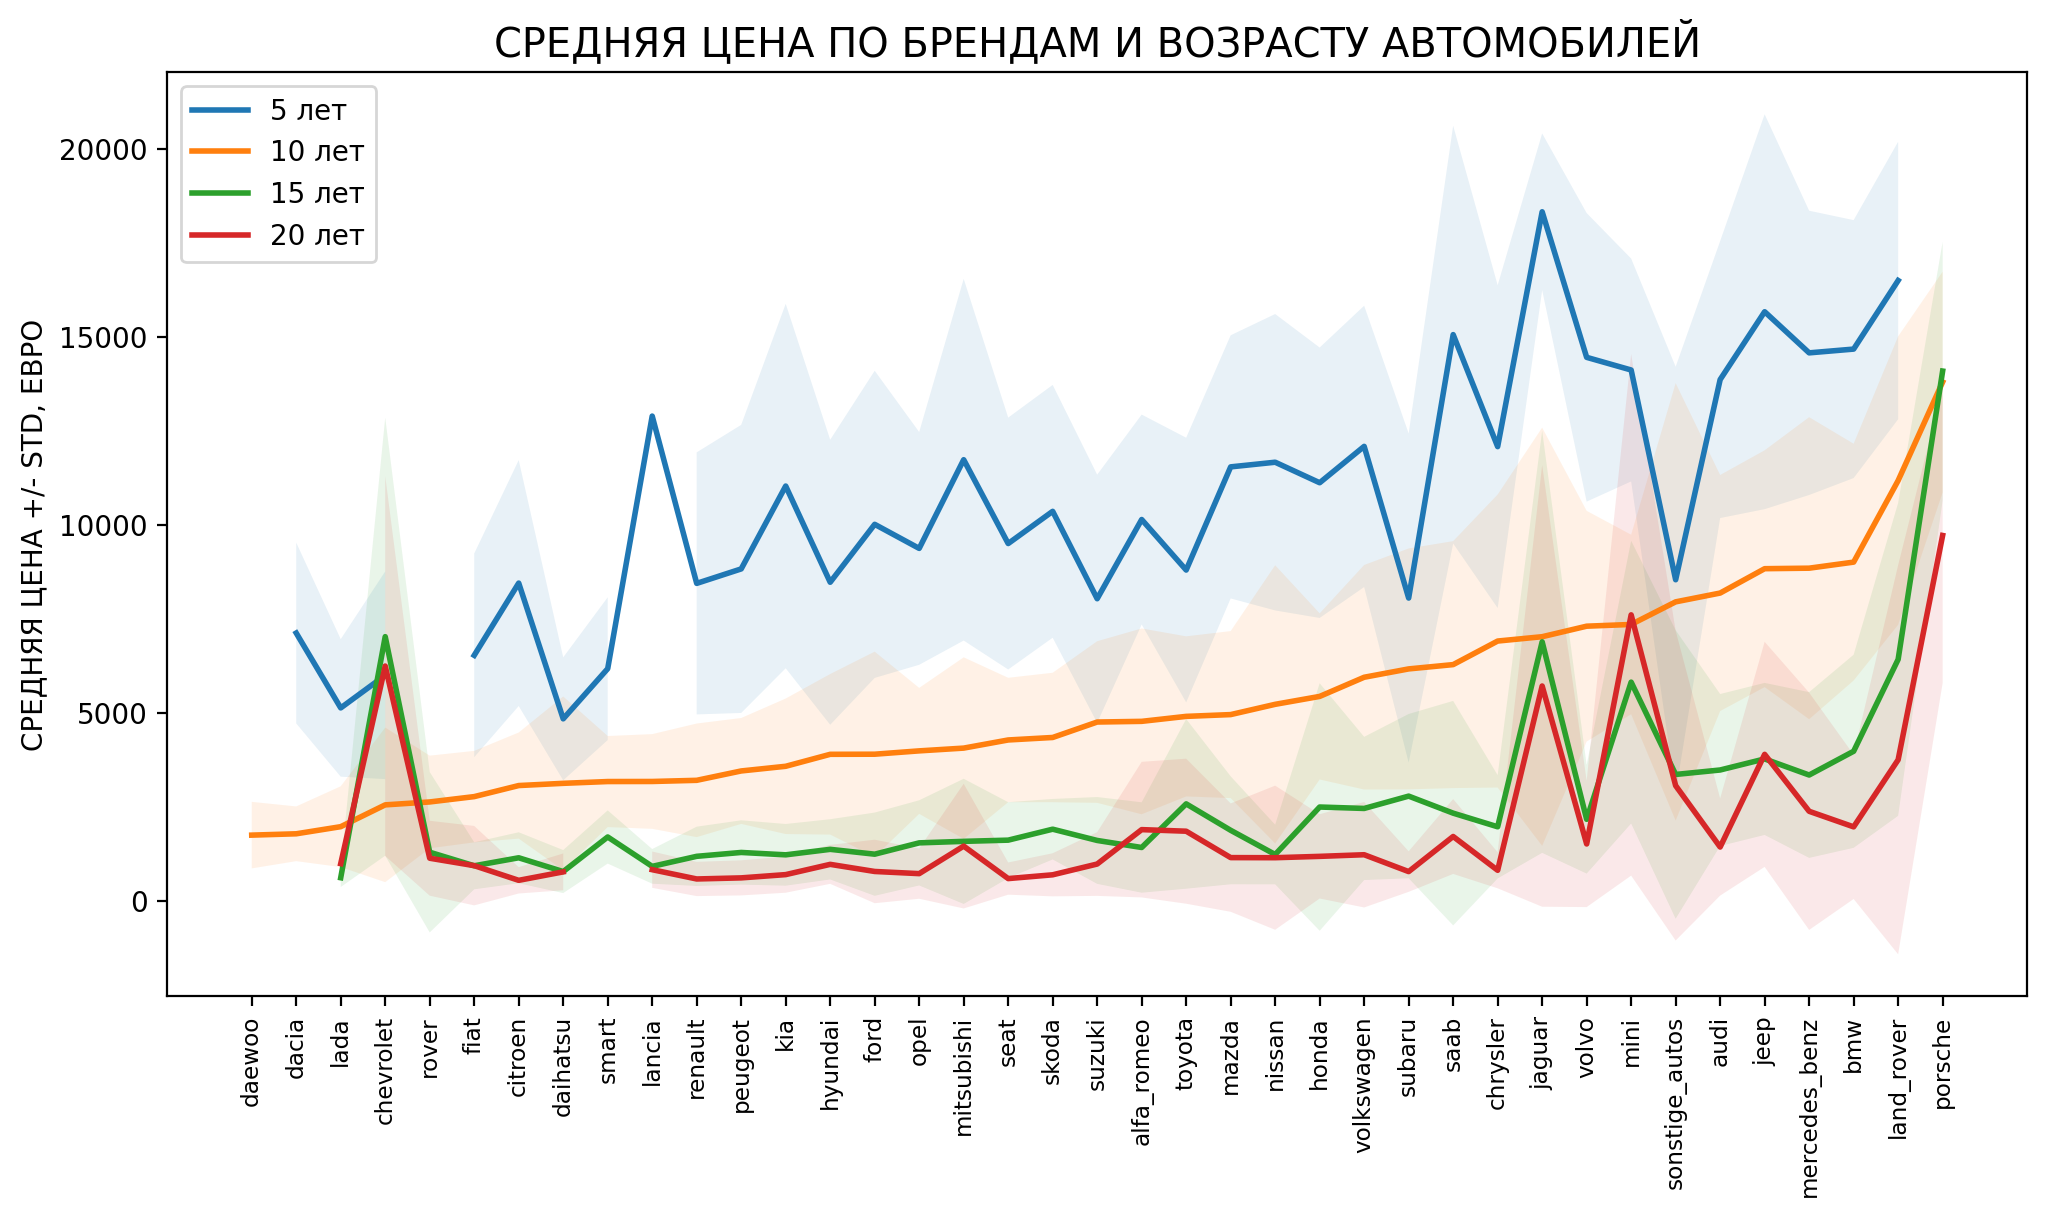

In [62]:
ages = [5, 10, 15, 20]
prices = df.loc[df.CarAge.isin(ages),
                ['CarAge', 'Brand', 'Price']].pivot_table(
                    index='Brand',
                    values='Price',
                    columns='CarAge',
                    aggfunc=['mean', 'std']).sort_values(by=('mean', 10))
fig = plt.figure(figsize=(12, 6))
for age in ages:
    plt.plot(prices.index,
             prices[('mean', age)],
             lw=2,
             label=f"{age} {'год' if age == 1 else 'лет'}")
    plt.fill_between(prices.index,
                     prices[('mean', age)] - prices[('std', age)],
                     prices[('mean', age)] + prices[('std', age)],
                     alpha=.1)
    plt.legend(loc='upper left')
    plt.xticks(rotation=90, fontsize='small')
    plt.title('Средняя цена по брендам и возрасту автомобилей'.upper(),
              fontsize='x-large')
    plt.ylabel('Средняя цена +/- std, евро'.upper())
plt.show()

Здесь мы видим, что возраст сильно влияет на цену, бренд меньше. Для редких брендов колебания цены больше.

#### Выводы

В результате исслеодовательского анализа данных мы изучили структуру данных, проанализировали пропуски и аномальные значения. 

Исследование позволило нам сделать следующее.

1. Обнаружить дубликаты и незначимые признаки.
1. Убедиться, что в данных нет ошибок заполнения.
1. Заменить признаки с типом дата-время `DateCreated`, `DateCrawled` целочисленным признаком `AnketaAge`, а также заменить три признака `DateCreated`, `RegistrationYear` и `RegistrationMonth` одним целочисленным признаком `CarAge`. 
1. Выяснить, что наибольшее количество объявлений имеет возраст автомобиля от 4 до 20 лет. 
1. Убедиться, что в датасете есть аномальные значения возраста автомобиля и мощности двигателя. На сайте [https://www.autoscout24.de](https://www.autoscout24.de) мы видим примеры объявлений с некорректными значениями вроде [микроавтобуса Пежо можностью 10 000 лошадиных сил](https://www.autoscout24.com/offers/peugeot-partner-premium-100-pk-650-kg-staat-in-bestelling-diesel-black-945154e4-b101-4346-a4d9-64c4eeb76db1?sort=power&desc=1&lastSeenGuidPresent=false&cldtidx=2&position=2&search_id=gnia8z6qkx&source_otp=t10&source=listpage_search-results), или [Ягуаром XF, зарегистрированным в 1900 году](https://www.autoscout24.com/offers/jaguar-xf-3-0-v6-luxury-aut-gasoline-black-d664dfaa-e2e5-153c-e053-0100007f683b?sort=standard&desc=0&lastSeenGuidPresent=false&cldtidx=4&position=4&search_id=1twmmj4jg4&source_otp=t10&source=listpage_search-results).
1. На сайте [https://www.autoscout24.de](https://www.autoscout24.de) мы также увидели, что кроме автомобилей в объявлениях могут встречаться запчасти, для которых нормальным является пропуск значений с характеристиками автомобиля вроде типа кузова или типа трансмиссии.

У нас нет сведений об источнике данных, но сравнение значений и типов данных нашего датасета с объявлениями на  [autoscout24.de](https://www.autoscout24.de) позволяет объяснить природу аномальных значений и пропусков и выбрать методы устранения аномалий и пропусков.


### Устранение аномалий и пропусков

На этапе исследовательского анализа данных мы выявили проблемы в датасете. Применем следующие методы для устранения аномалий и пропусков:

1. Наличие дубликатов — удалим.
1. Пропуски в целевом признаке `Price` и объявления со стоимостью меньше 300 евро — удалим.
1. Строковый тип у признаков `DateCreated` и `DateCrowled` — заменим на DateTime
1. Нулевые значения в признаке `RegistrationMonth` — заменим признаки `DateCreated`, `RegistrationYear` и `RegistrationMonth` одним целочисленным признаком 
$\mathit{CarAge} = \mathit{round}((\mathit{RegistrationYear} \times 12 + \mathit{RegistrationMonth} - \mathit{year}(\mathit{DateCreated}) \times 12 -  \mathit{month}(\mathit{DateCreated})) / 12)$.
1. Пропуски в признаках `Model` и `VehicleType` — удалим объекты с пропусками.
1. Пропуски `Gearbox`, `FuelType` и`NotRepaired` заполним значением `unknown`.
1. Объявления с возрастом автомобилей `CarAge` меньше 4х лет и больше 20 лет удалим.
1. Значения мощности  менее 50 и более 250 заменим на `NaN`, после чего заполним пропуски средним значением мощности для марки и модели в объявлении. Если среднее значение посчитать не сможем, удалим объявления с пропусками мощности.
1. Добавим расчетный признак $\mathit{AnketaAge} = \mathit{DateCrawled} - \mathit{DateCreated} $
1. Добавим рассчетный признак `BrandModel = Brand+Model`

Для выполнения этих действий мы [определили функции очистки данных](#Очистка-данных), а также [класс CarPower](#CarPower) с методами fit и transform.

In [63]:
del(df)

Сохраним шаги по очистке данных в списке.

In [64]:
steps_before = [
    convert_str_to_datetime,
    remove_duplicates,
    drop_na_rows_model_type,
    filter_price,
    add_car_age_feature,
    add_brandmodel_feature,
    add_anketa_age_feature,
    filter_age,
    replace_power_outliers,
]

steps_after = [
    drop_na_rows_power,
    drop_unused_features,
    fill_na_with_unknown
]

Очистим обучающий датасет.

In [65]:
train_data = X_train.join(y_train)
clean_df = clear_data(train_data.copy(), steps_before)
clean_df.shape

(202124, 19)

Рассчитаем средние значения мощности двигателей для марок и моделей автомобилей.

In [66]:
cars_power = CarPower()
cars_power.fit(clean_df)

In [67]:
clean_df = cars_power.transform(clean_df)

In [68]:
clean_df = clear_data(clean_df, steps_after)
clean_df.shape

(202089, 12)

In [69]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202089 entries, 0 to 279201
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   VehicleType  202089 non-null  object 
 1   Gearbox      202089 non-null  object 
 2   Power        202089 non-null  float64
 3   Model        202089 non-null  object 
 4   Kilometer    202089 non-null  int64  
 5   FuelType     202089 non-null  object 
 6   Brand        202089 non-null  object 
 7   NotRepaired  202089 non-null  object 
 8   PostalCode   202089 non-null  int64  
 9   Price        202089 non-null  int64  
 10  CarAge       202089 non-null  int64  
 11  AnketaAge    202089 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 20.0+ MB


Сохраним часть данных без обработки аномальных значений для проверки качества очистки данных.

In [70]:
loose_cleaned_data = clear_data(
    train_data.sample(frac=.2, random_state=RANDOM_STATE),
    [convert_str_to_datetime, remove_duplicates, remove_empty_price_rows])

loose_cleaned_data = loose_cleaned_data.fillna('unknown')


del(train_data)

В качестве признаков возьмем:
- численные: AnketaAge, CarAge, Power, Kilometer, PostalCode
- категориальные: 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'

In [71]:
numerical_features = ['AnketaAge', 'CarAge', 'Power', 'Kilometer', 'PostalCode']
categorical_features = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'NotRepaired']

In [72]:
clean_df[numerical_features].describe()

,AnketaAge,CarAge,Power,Kilometer,PostalCode
count,202089.000000,202089.000000,202089.000000,202089.000000,202089.000000
mean,0.850863,12.261538,120.554054,130891.909010,51204.977159
std,1.689966,4.341254,45.575007,33216.527791,25560.211262
min,0.000000,4.000000,50.000000,5000.000000,1067.000000
25%,1.000000,9.000000,82.000000,125000.000000,31020.000000
50%,1.000000,12.000000,116.000000,150000.000000,50321.000000
75%,1.000000,16.000000,150.000000,150000.000000,71577.000000
max,370.000000,20.000000,250.000000,150000.000000,99998.000000


In [73]:
clean_df[categorical_features].describe()

,VehicleType,Gearbox,Brand,Model,FuelType,NotRepaired
count,202089,202089,202089,202089,202089,202089
unique,8,3,38,243,8,3
top,sedan,manual,volkswagen,golf,petrol,no
freq,57406,155584,41564,15412,124122,155892


Подготовим обучающую выборку.

In [74]:
X_train = clean_df[categorical_features+numerical_features]
y_train = clean_df.Price

In [75]:
del(clean_df)

Очистим тестовый датасет.

In [76]:
X_train.shape, y_train.shape

((202089, 11), (202089,))

In [77]:
clean_test_df = clear_data(X_test.join(y_test), steps_before)
clean_test_df.shape

(51251, 19)

In [78]:
clean_test_df = cars_power.transform(clean_test_df)

In [79]:
clean_test_df = clear_data(clean_test_df, steps_after)
clean_test_df.shape

(51242, 12)

In [80]:
X_test = clean_test_df[categorical_features+numerical_features]
y_test = clean_test_df.Price

In [81]:
X_test.shape, y_test.shape

((51242, 11), (51242,))

In [82]:
del(clean_test_df)

### Выводы

Мы изучили структуру и качество данных. В данных выявили пропуски и аномальные значения. Анализ сайта с объявлениями о прожаже автомобилей  [autoscout24.de](https://www.autoscout24.de) позволяет объяснить природу аномальных значений и пропусков. 


Исходя из цели проекта — предсказания цены автомобиля — мы определили область примениения модели: 
- возраст автомобиля от 4 до 20 лет включительно,
- обязательно наличие информации о типе автомобильного кузова и моодели,
- мощность автомобиля от 50 до 250 лс включительно,
- минимальная стоимость 300 евро.

## Обучение моделей

Поскольку у нас ограничены вычислительные ресурсы, для анализа работы моделей возьмем сэмпл в объеме 20% обучающей выборки. На этом сэмрле проанализируем точность и время работы разных моделей.

Лучшую модель обучим на всей обучающей выборке с подобранными гиперпараметрами и протестируем ее качество на тестовой выборке.


In [83]:
sample = X_train.join(y_train).sample(frac=.2, random_state=RANDOM_STATE)
X_sample = sample.drop('Price', axis=1)
y_sample = sample.Price
del(sample)
X_sample.shape, y_sample.shape

((40418, 11), (40418,))

Для оценки результатов будем использовать кросс-валидацию методом RepeatedKFold с пятью фолдами и тремя повторами. 

In [84]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

Замерим базовые значения RMSE для линейной регресии и Dummy-модели, возрвращающей в качестве прогноза среднее значение целевого признака.

In [85]:
column_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(
        dtype='int', handle_unknown='ignore'), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [86]:
pipeline_lr = make_pipeline(column_transformer, LinearRegression(n_jobs=-1))
pipeline_dm = make_pipeline(column_transformer, DummyRegressor())

In [87]:
%%time
for est, name in zip([pipeline_lr, pipeline_dm], ['Linear Regression', 'Dummy Regression']): 
    print(name)
    cross_validate_model(est, X_sample, y_sample)

Linear Regression
fit time	 0.86s +/- 0.09s
score time	 0.04s +/- 0.00s
RMSE		 2111 +/- -33
R2 		 0.770 +/- 0.005

Dummy Regression
fit time	 0.11s +/- 0.02s
score time	 0.04s +/- 0.01s
RMSE		 4399 +/- -47
R2 		 -0.000 +/- 0.000

CPU times: user 526 ms, sys: 202 ms, total: 728 ms
Wall time: 4.74 s


Мы видим, что RMSE линейной регрессии почти в два раза лучше случайной модели. Значит наша модель состоятельна. Уже эта модель позволяет достичь заданного коитерия качества RMSE меньше 2500. 

### Проверка очистки данных

В процессе очистки данных мы преобразовали признаки и ограничили значения  мощности и возраста автомобилей. Также мы заменили пропуски категориальных признаков значением 'unknown'. Сравним результаты обучения моделей на очищенных данных с результатами на данных без очистки: в исходном датесете только преобразуем признаки с датой из строкового типа в DateTime и заполним пропуски на 'unknown'.

In [88]:
loose_cleaned_data_columns_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(dtype='int', handle_unknown='ignore'),
      ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'NotRepaired']),
     ('numerical', StandardScaler(), [
         'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
         'PostalCode'
     ])],
    remainder='drop')
loose_cleaned_data_pipeline = make_pipeline(
    loose_cleaned_data_columns_transformer, LinearRegression(n_jobs=-1))

In [89]:
print('Cleaned dataset')
cross_validate_model(pipeline_lr, X_sample, y_sample)

print('Dataset without cleaning')
cross_validate_model(loose_cleaned_data_pipeline,
                     loose_cleaned_data.drop('Price', axis=1),
                     loose_cleaned_data.Price)

print()

Cleaned dataset
fit time	 0.80s +/- 0.07s
score time	 0.03s +/- 0.01s
RMSE		 2111 +/- -28
R2 		 0.770 +/- 0.005

Dataset without cleaning
fit time	 1.00s +/- 0.03s
score time	 0.05s +/- 0.00s
RMSE		 3132 +/- -24
R2 		 0.522 +/- 0.006




Видим, что очистка признаков дала результаты. Без нее RMSE больше 2500.

### Выбор признаков

Последовательно удалим из признаков по одному и оценим качетсво модели без каждого признака.

In [90]:
removed_columns, scores = [], []

for column in numerical_features:
    reduced_numerical_features = numerical_features.copy()
    reduced_numerical_features.remove(column)

    removed_columns.append(column)
    scores.append(
        get_cv_result(X_sample, y_sample, reduced_numerical_features,
                      categorical_features, cv))

    print(column, reduced_numerical_features, f'{scores[-1]:.3f}')

    
for column in categorical_features:
    reduced_categorical_features = categorical_features.copy()
    reduced_categorical_features.remove(column)

    removed_columns.append(column)
    scores.append(
        get_cv_result(X_sample, y_sample, numerical_features,
                      reduced_categorical_features, cv))
    
    print(column, reduced_categorical_features, f'{scores[-1]:.3f}')

    
features_impact = pd.DataFrame({'removed_column': removed_columns, 'rmse': scores})    

AnketaAge ['CarAge', 'Power', 'Kilometer', 'PostalCode'] 0.770
CarAge ['AnketaAge', 'Power', 'Kilometer', 'PostalCode'] 0.606
Power ['AnketaAge', 'CarAge', 'Kilometer', 'PostalCode'] 0.752
Kilometer ['AnketaAge', 'CarAge', 'Power', 'PostalCode'] 0.753
PostalCode ['AnketaAge', 'CarAge', 'Power', 'Kilometer'] 0.769
VehicleType ['Gearbox', 'Brand', 'Model', 'FuelType', 'NotRepaired'] 0.764
Gearbox ['VehicleType', 'Brand', 'Model', 'FuelType', 'NotRepaired'] 0.767
Brand ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'] 0.764
Model ['VehicleType', 'Gearbox', 'Brand', 'FuelType', 'NotRepaired'] 0.740
FuelType ['VehicleType', 'Gearbox', 'Brand', 'Model', 'NotRepaired'] 0.770
NotRepaired ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType'] 0.763


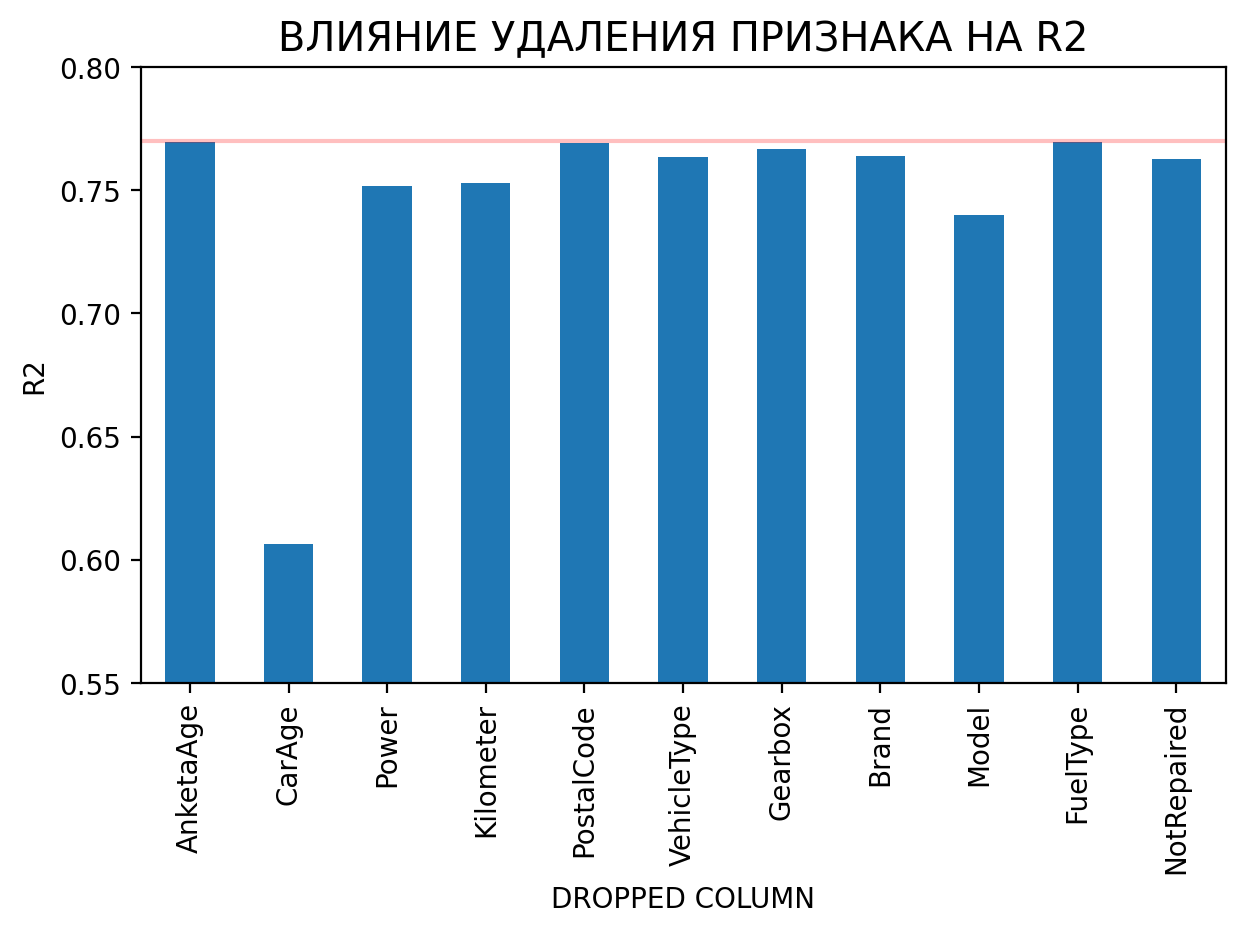

In [91]:
ax = features_impact.plot.bar(xticks=features_impact.index,
                              rot=90,
                              figsize=(7, 4),
                              legend=None)
ax.set_xticklabels(features_impact.removed_column)
plt.axhline(.77, c='r', alpha=.25)
plt.title('Влияние удаления признака на R2'.upper(), fontsize='x-large')
plt.xlabel('Dropped column'.upper())
plt.ylabel('R2'.upper())
plt.ylim(.55, .8)
plt.show()

Мы видим, что удаление `AnketaAge`, `PostalCode`, `FuelType` не сказываются на результатах модели. Удалим эти 3 признака как не значащие. 

Больше всего на R2 влияет возраст автомобиля, пробег, мощность и модель.

In [92]:
numerical_features.remove('AnketaAge')
numerical_features.remove('PostalCode')

numerical_features

['CarAge', 'Power', 'Kilometer']

In [93]:
categorical_features.remove('FuelType')

categorical_features

['VehicleType', 'Gearbox', 'Brand', 'Model', 'NotRepaired']

### Обучение моделей

Обучим модели на алгоритмах  LinearRegression, DecisionTreeRegressor, HistGradientBoostingRegressor и LGBMRegressor. Поскольку два последних алгоритма имеют встроенную обработку категориальных переменных, обучим по две версии моделей на них: первую с использованием OHE-кодирования категориальных признаков, вторую с использованием встроенной обработки категориальных переменных.

In [94]:
ohe_sparse_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(
        dtype='int', handle_unknown='ignore'), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [95]:
ohe_dense_transformer = ColumnTransformer(
    [('categorical',
      OneHotEncoder(dtype='int', handle_unknown='ignore',
                    sparse=False), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [96]:
ordinal_transformer = ColumnTransformer(
    [('categorical',
      OrdinalEncoder(handle_unknown="use_encoded_value",
                     unknown_value=np.nan), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [97]:
categorical_mask = [True] * len(categorical_features) + [False] * len(
    numerical_features)
fit_params = {
    'lgbmregressor__categorical_feature':
    [_ for _ in range(len(categorical_features))]
}

In [98]:
baseline_estimators = [
    make_pipeline(ohe_sparse_transformer, LinearRegression(n_jobs=-1)),
    make_pipeline(
        ohe_sparse_transformer,
        DecisionTreeRegressor(min_samples_leaf=100, random_state=RANDOM_STATE)),
    make_pipeline(
        ohe_dense_transformer,
        HistGradientBoostingRegressor(min_samples_leaf=31,
                                      random_state=RANDOM_STATE)),
    make_pipeline(
        ordinal_transformer,
        HistGradientBoostingRegressor(min_samples_leaf=31,
                                      categorical_features=categorical_mask,
                                      random_state=RANDOM_STATE)),
    make_pipeline(ohe_sparse_transformer,
                  LGBMRegressor(random_state=RANDOM_STATE)),
    make_pipeline(ordinal_transformer,
                  LGBMRegressor(random_state=RANDOM_STATE)),
]

In [99]:
scores = dict()
for est, name in zip(baseline_estimators, [
        'LinearRegression', 'DecisionTree',
        'HistGradientBoosting OHE',
        'HistGradientBoosting & categorical', 'LGBM OHE',
        'LGBM & categorical'
]):
    print(name)
    params = fit_params if name == 'LGBM & categorical' else dict()
    scores[name] = cross_validate_model(est,
                                        X_sample,
                                        y_sample,
                                        fit_params=params)

LinearRegression
fit time	 0.66s +/- 0.07s
score time	 0.03s +/- 0.01s
RMSE		 2115 +/- -19
R2 		 0.769 +/- 0.005

DecisionTree
fit time	 0.50s +/- 0.02s
score time	 0.03s +/- 0.01s
RMSE		 2091 +/- -28
R2 		 0.774 +/- 0.005

HistGradientBoosting OHE
fit time	 11.22s +/- 0.76s
score time	 0.41s +/- 0.03s
RMSE		 1634 +/- -19
R2 		 0.862 +/- 0.004

HistGradientBoosting & categorical
fit time	 1.24s +/- 0.05s
score time	 0.21s +/- 0.02s
RMSE		 1564 +/- -23
R2 		 0.874 +/- 0.004

LGBM OHE
fit time	 0.53s +/- 0.02s
score time	 0.16s +/- 0.02s
RMSE		 1621 +/- -39
R2 		 0.864 +/- 0.007

LGBM & categorical


/Volumes/T7/working/yp13-gradient-boosting/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/yp13-gradient-boosting/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/yp13-gradient-boosting/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/yp13-gradient-boosting/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/yp13-gradient-boosting/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using

fit time	 0.51s +/- 0.05s
score time	 0.13s +/- 0.01s
RMSE		 1562 +/- -35
R2 		 0.874 +/- 0.005



Использование LGBM со Scikit-learn API приводит к предупреждениям об использовании категориальных признаков из датасета при указании индексов в параметре `categorical_feature`. Чтобы избежать предупреждений в дальнейшем подготовим признаки в pandas DataFrame с типом categorical.

Сделаем визуальный анализ полученных результатов.

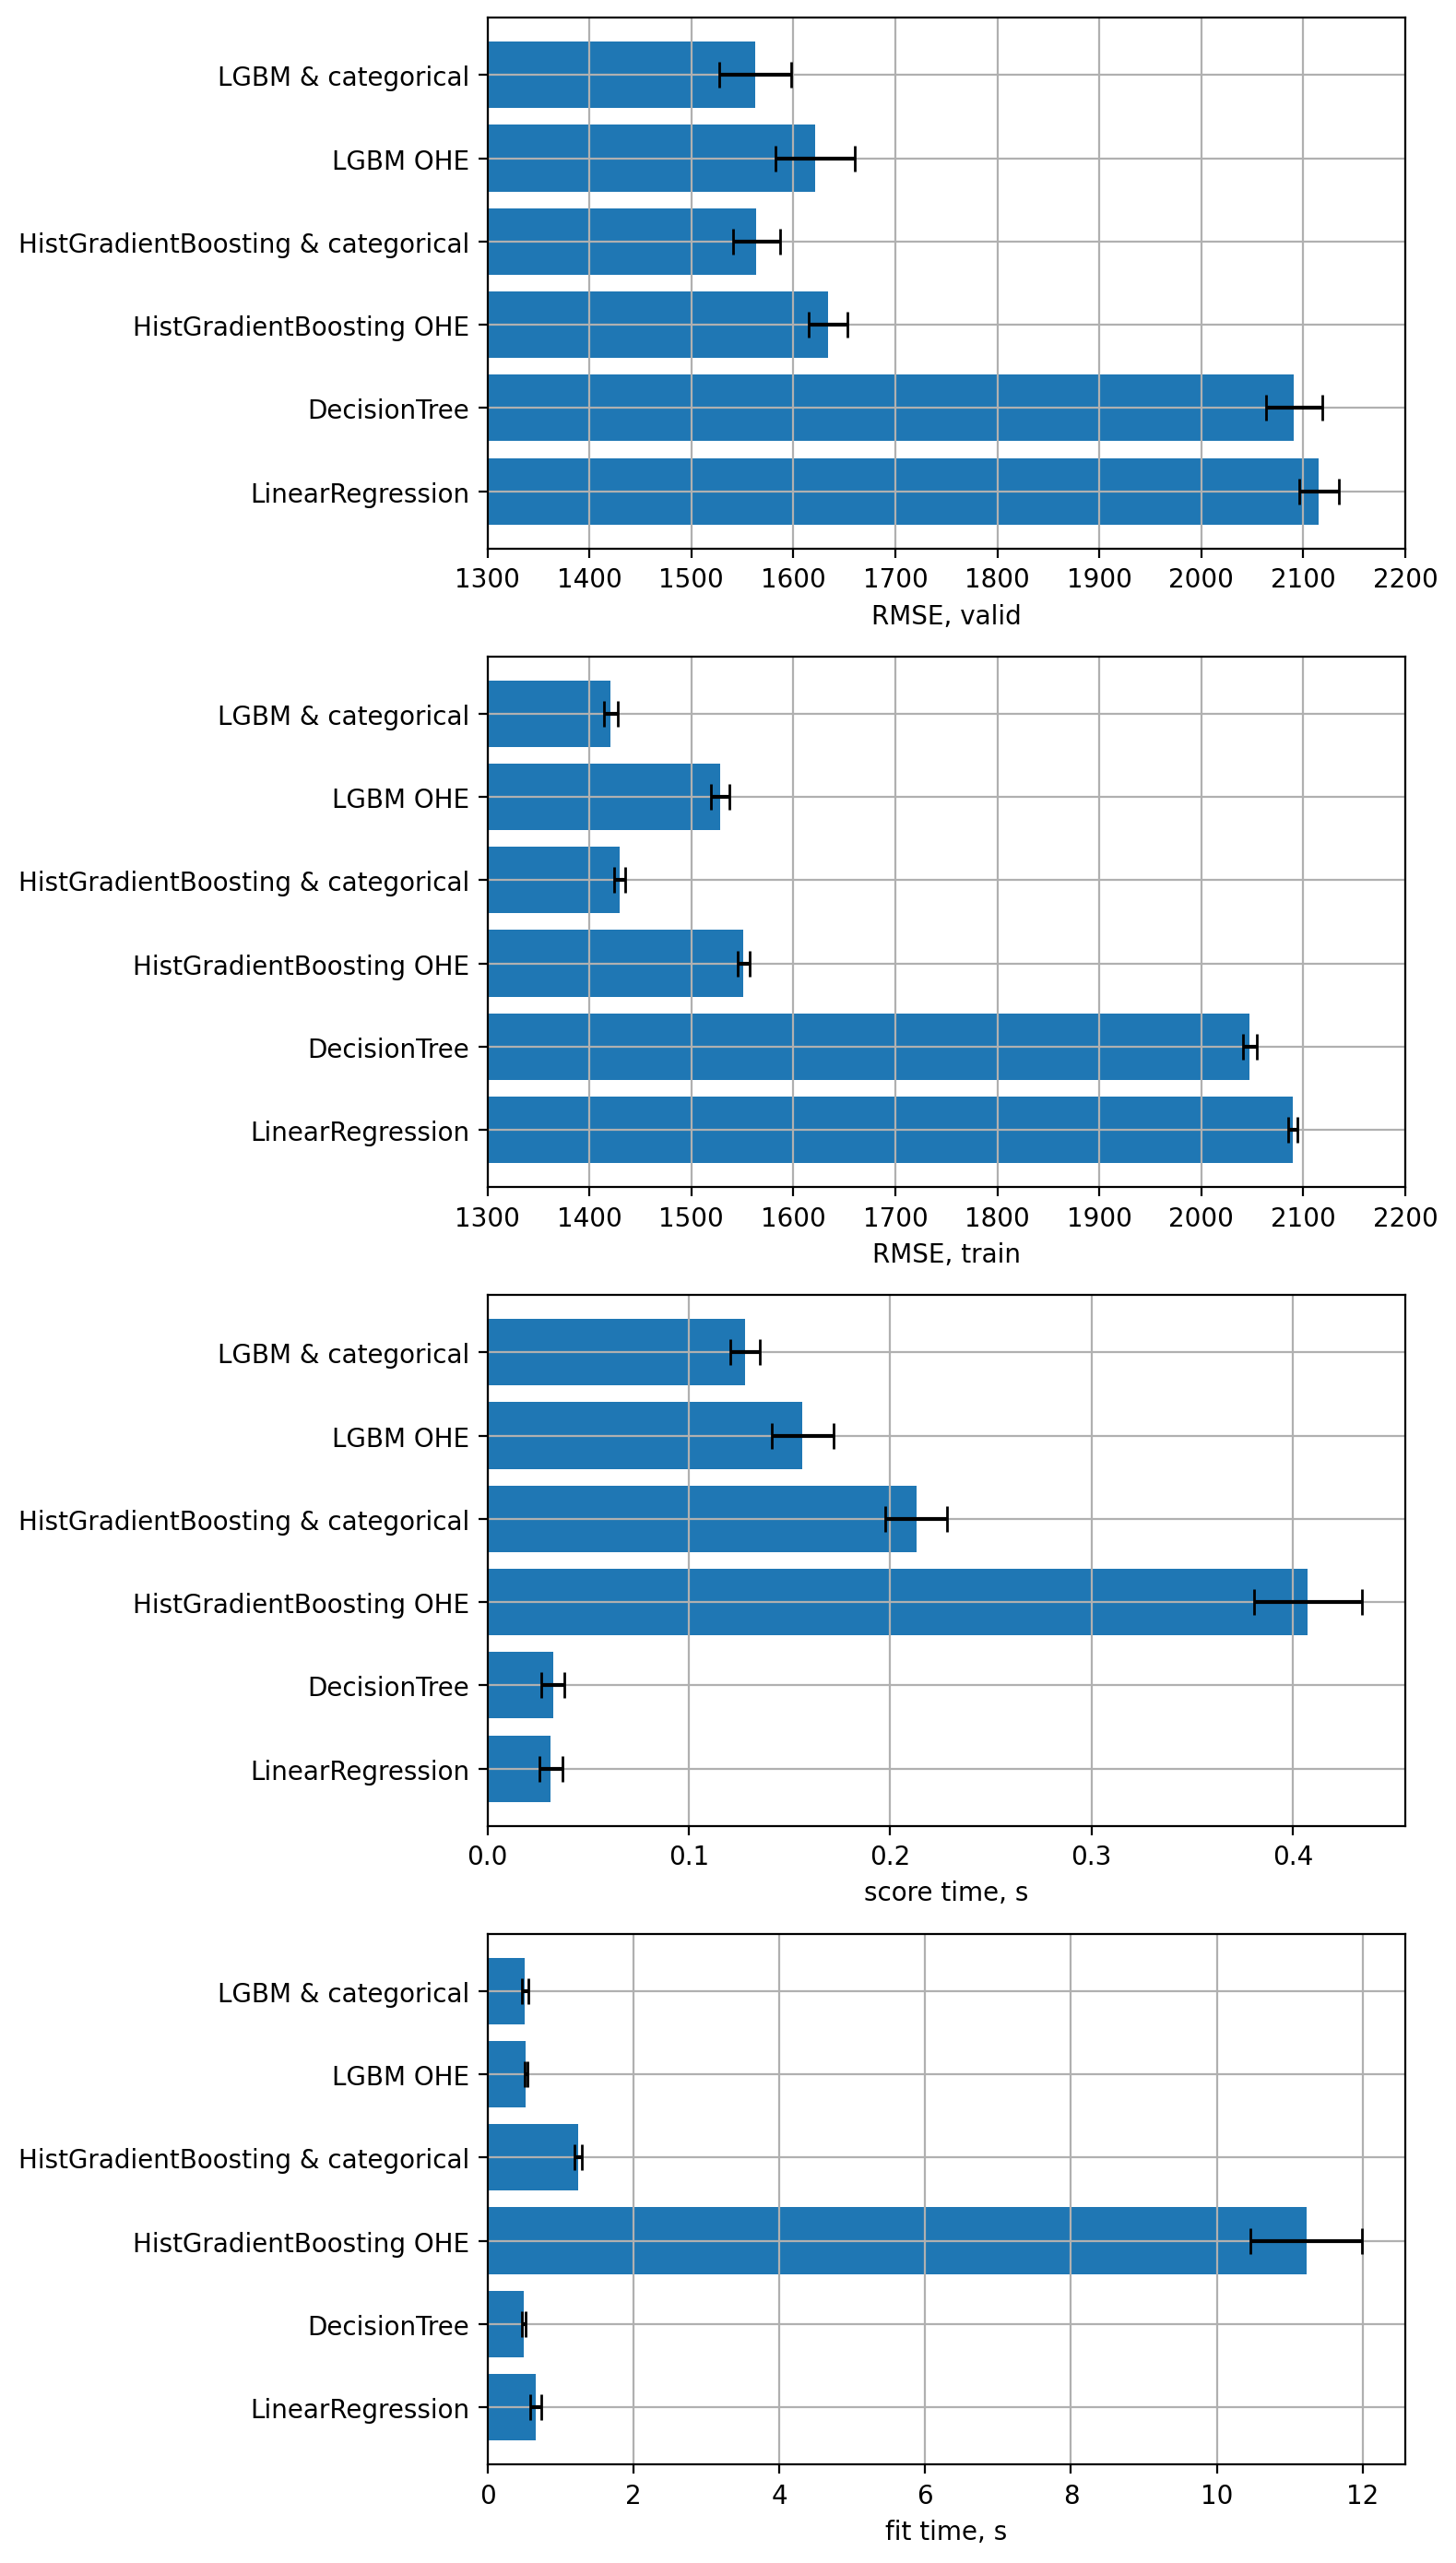

In [100]:
fig, axes = plt.subplots(4, 1, figsize=(8, 14))

labels = list(scores.keys())
y_pos = range(len(labels))

test_rmse = get_scoring_values(scores, "test_neg_root_mean_squared_error")
plot_comaprison_bar(axes[0], -1 * test_rmse.mean(axis=1),
                    test_rmse.std(axis=1), labels, "RMSE, valid", xlim=(1300,2200))

train_rmse = get_scoring_values(scores, "train_neg_root_mean_squared_error")
plot_comaprison_bar(axes[1], -1 * train_rmse.mean(axis=1),
                    train_rmse.std(axis=1), labels, "RMSE, train", xlim=(1300,2200))

score_time = get_scoring_values(scores, "score_time")
plot_comaprison_bar(axes[2], score_time.mean(axis=1), score_time.std(axis=1),
                    labels, "score time, s")

fit_time = get_scoring_values(scores, "fit_time")
plot_comaprison_bar(axes[3], fit_time.mean(axis=1), fit_time.std(axis=1),
                    labels, "fit time, s")

plt.tight_layout()
plt.show()

Лучшее качество предсказания дают модели на HistGradientBoosting и LGBM при использовании встроенной обработки категориальных признаков. Худшее - LinearRegression.

Наименьшее время предсказания у моделей LinearRegression и DecisionTree. Среди моделей с лучшим качеством предсказания время предсказания у LGBM в 1.7 раз меньше, чем у HistGradientBoosting.

Время обучения у всех моделей сопоставимо за исключением HistGradientBoosting, который обучается дольше всех, особенно при использовании OHE-кодирования. 

В данном сравнении мы оценивали алгоритмы с утсановлеными по умолчанию значениями гиперпараметров.

Из рассмотренных алгоритмов по совокупности критериев качество, время предсказания и время обучения лучше всего себя показывают DecisionTree, LGBM и HistGradientBoosting с внутренней обработкой категориальных признаков.

Проанализируем эти модели при разных значениях гиперпараметров.

### Подбор гиперпараметров

Подготовим данные с закодированными категориальными признаками и масштабированными числовыми.

In [101]:
X_sample = pd.DataFrame(ordinal_transformer.fit_transform(X_sample),
                        columns=categorical_features + numerical_features)

for column in categorical_features:
    X_sample[column] = pd.Categorical(X_sample[column])
X_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40418 entries, 0 to 40417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   VehicleType  40418 non-null  category
 1   Gearbox      40418 non-null  category
 2   Brand        40418 non-null  category
 3   Model        40418 non-null  category
 4   NotRepaired  40418 non-null  category
 5   CarAge       40418 non-null  float64 
 6   Power        40418 non-null  float64 
 7   Kilometer    40418 non-null  float64 
dtypes: category(5), float64(3)
memory usage: 1.2 MB


In [102]:
X_sample.head()

,VehicleType,Gearbox,Brand,Model,NotRepaired,CarAge,Power,Kilometer
0,2.0,1.0,20.0,55.0,0.0,0.409064,0.185851,0.577559
1,4.0,1.0,30.0,134.0,2.0,-1.430911,-0.340202,0.577559
2,5.0,1.0,9.0,170.0,1.0,0.869058,-1.326552,-0.174549
3,4.0,1.0,19.0,15.0,0.0,1.099055,-0.099094,0.577559
4,2.0,1.0,20.0,72.0,1.0,1.099055,0.339283,0.577559


#### DecisionTreeRegressor

In [103]:
dt_param_distributions = {
    'max_depth': np.arange(100, 600, 100),
    'min_samples_split': [2**i for i in range(4, 11)],
    'min_samples_leaf': [2**i for i in range(3, 9)]
}

In [104]:
dt_search_estimator = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_distributions=dt_param_distributions,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=False,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

In [105]:
%%time
try:
    dt_search_results = load_object('dt_search_results.pkl')  
except:
    dt_search_results = dt_search_estimator.fit(X_sample, y_sample)
    if path.isdir('data'):
        save_object('data/dt_search_results.pkl', dt_search_results)    

data is loaded
CPU times: user 20.9 ms, sys: 8.63 ms, total: 29.6 ms
Wall time: 413 ms


#### LGBMRegressor

In [106]:
lgbm_param_distributions = {
    'n_estimators': np.arange(200, 1600, 100),
    'num_leaves': [2**i for i in range(3, 9)],
    'learning_rate': np.logspace(-2, 1, num=20, endpoint=True, base=10, dtype=float, axis=0),
    'subsample': [0.3, 0.5, 0.7, 0.9, 1],
    'subsample_freq': [5, 25, 625],
    'min_child_samples': np.arange(25, 275, 25),
    'reg_lambda': np.append([0],
                    np.logspace(0,
                                3,
                                num=20,
                                endpoint=True,
                                base=10,
                                dtype=float,
                                axis=0)),
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1]
}

In [107]:
lgbm_search_estimator = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=RANDOM_STATE),
    param_distributions=lgbm_param_distributions,
    n_iter=200,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=False,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

In [108]:
%%time
try:
    lgbm_search_results = load_object('lgbm_search_results.pkl')
except:
    lgbm_search_results = lgbm_search_estimator.fit(X_sample, y_sample)
    if path.isdir('data'):
        save_object('data/lgbm_search_results.pkl', lgbm_search_results)    

data is loaded
CPU times: user 14.3 ms, sys: 4.46 ms, total: 18.8 ms
Wall time: 494 ms


#### HistGradientBoostingRegressor

In [109]:
hgbr_param_distributions = {
    'max_iter': np.arange(100, 1600, 100),
    'max_leaf_nodes': [2**i for i in range(1, 9)],
    'learning_rate': np.logspace(-2, 1, num=20, endpoint=True, base=10, dtype=float, axis=0),
    'min_samples_leaf': np.arange(25, 275, 25),
    'l2_regularization': np.append([0],
                    np.logspace(0,
                                3,
                                num=20,
                                endpoint=True,
                                base=10,
                                dtype=float,
                                axis=0))
}

In [110]:
hgbr_search_estimator = RandomizedSearchCV(
    estimator=HistGradientBoostingRegressor(
        categorical_features=categorical_mask, random_state=RANDOM_STATE),
    param_distributions=hgbr_param_distributions,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=False,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True)

In [111]:
%%time
try:
    hgbr_search_results = load_object('hgbr_search_results.pkl')  
except:
    hgbr_search_results = hgbr_search_estimator.fit(X_sample, y_sample)
    if path.isdir('data'):
        save_object('data/hgbr_search_results.pkl', hgbr_search_results)    

data is loaded
CPU times: user 15.3 ms, sys: 4.31 ms, total: 19.6 ms
Wall time: 464 ms


### Анализ моделей

Выделим интересующие нас параметры из результатов подбора гиперпараметров.

In [112]:
results_columns = [
    'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
    'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score',
    'params', 'rank_test_score'
]

Отфильтруем те эксперименты, которые показали валидационный RMSE меньше 1600. Также исключим эксерименты с нихким RMSE при обучении, чтобы избежать переобучения.

In [113]:
dt_results = pd.DataFrame(
    dt_search_results.cv_results_)[results_columns].query(
        'mean_test_score > -1950').sort_values(by="mean_test_score")


lgbm_results = pd.DataFrame(
    lgbm_search_results.cv_results_)[results_columns].query(
        'mean_test_score > -1600 and mean_train_score < -1400').sort_values(by="mean_test_score")


hgbr_results = pd.DataFrame(
    hgbr_search_results.cv_results_)[results_columns].query(
        'mean_test_score > -1600 and mean_train_score < -1400').sort_values(by="mean_test_score")

Построим графики изменения показателей качества моделей по возрастанию валидационного RMSE. 

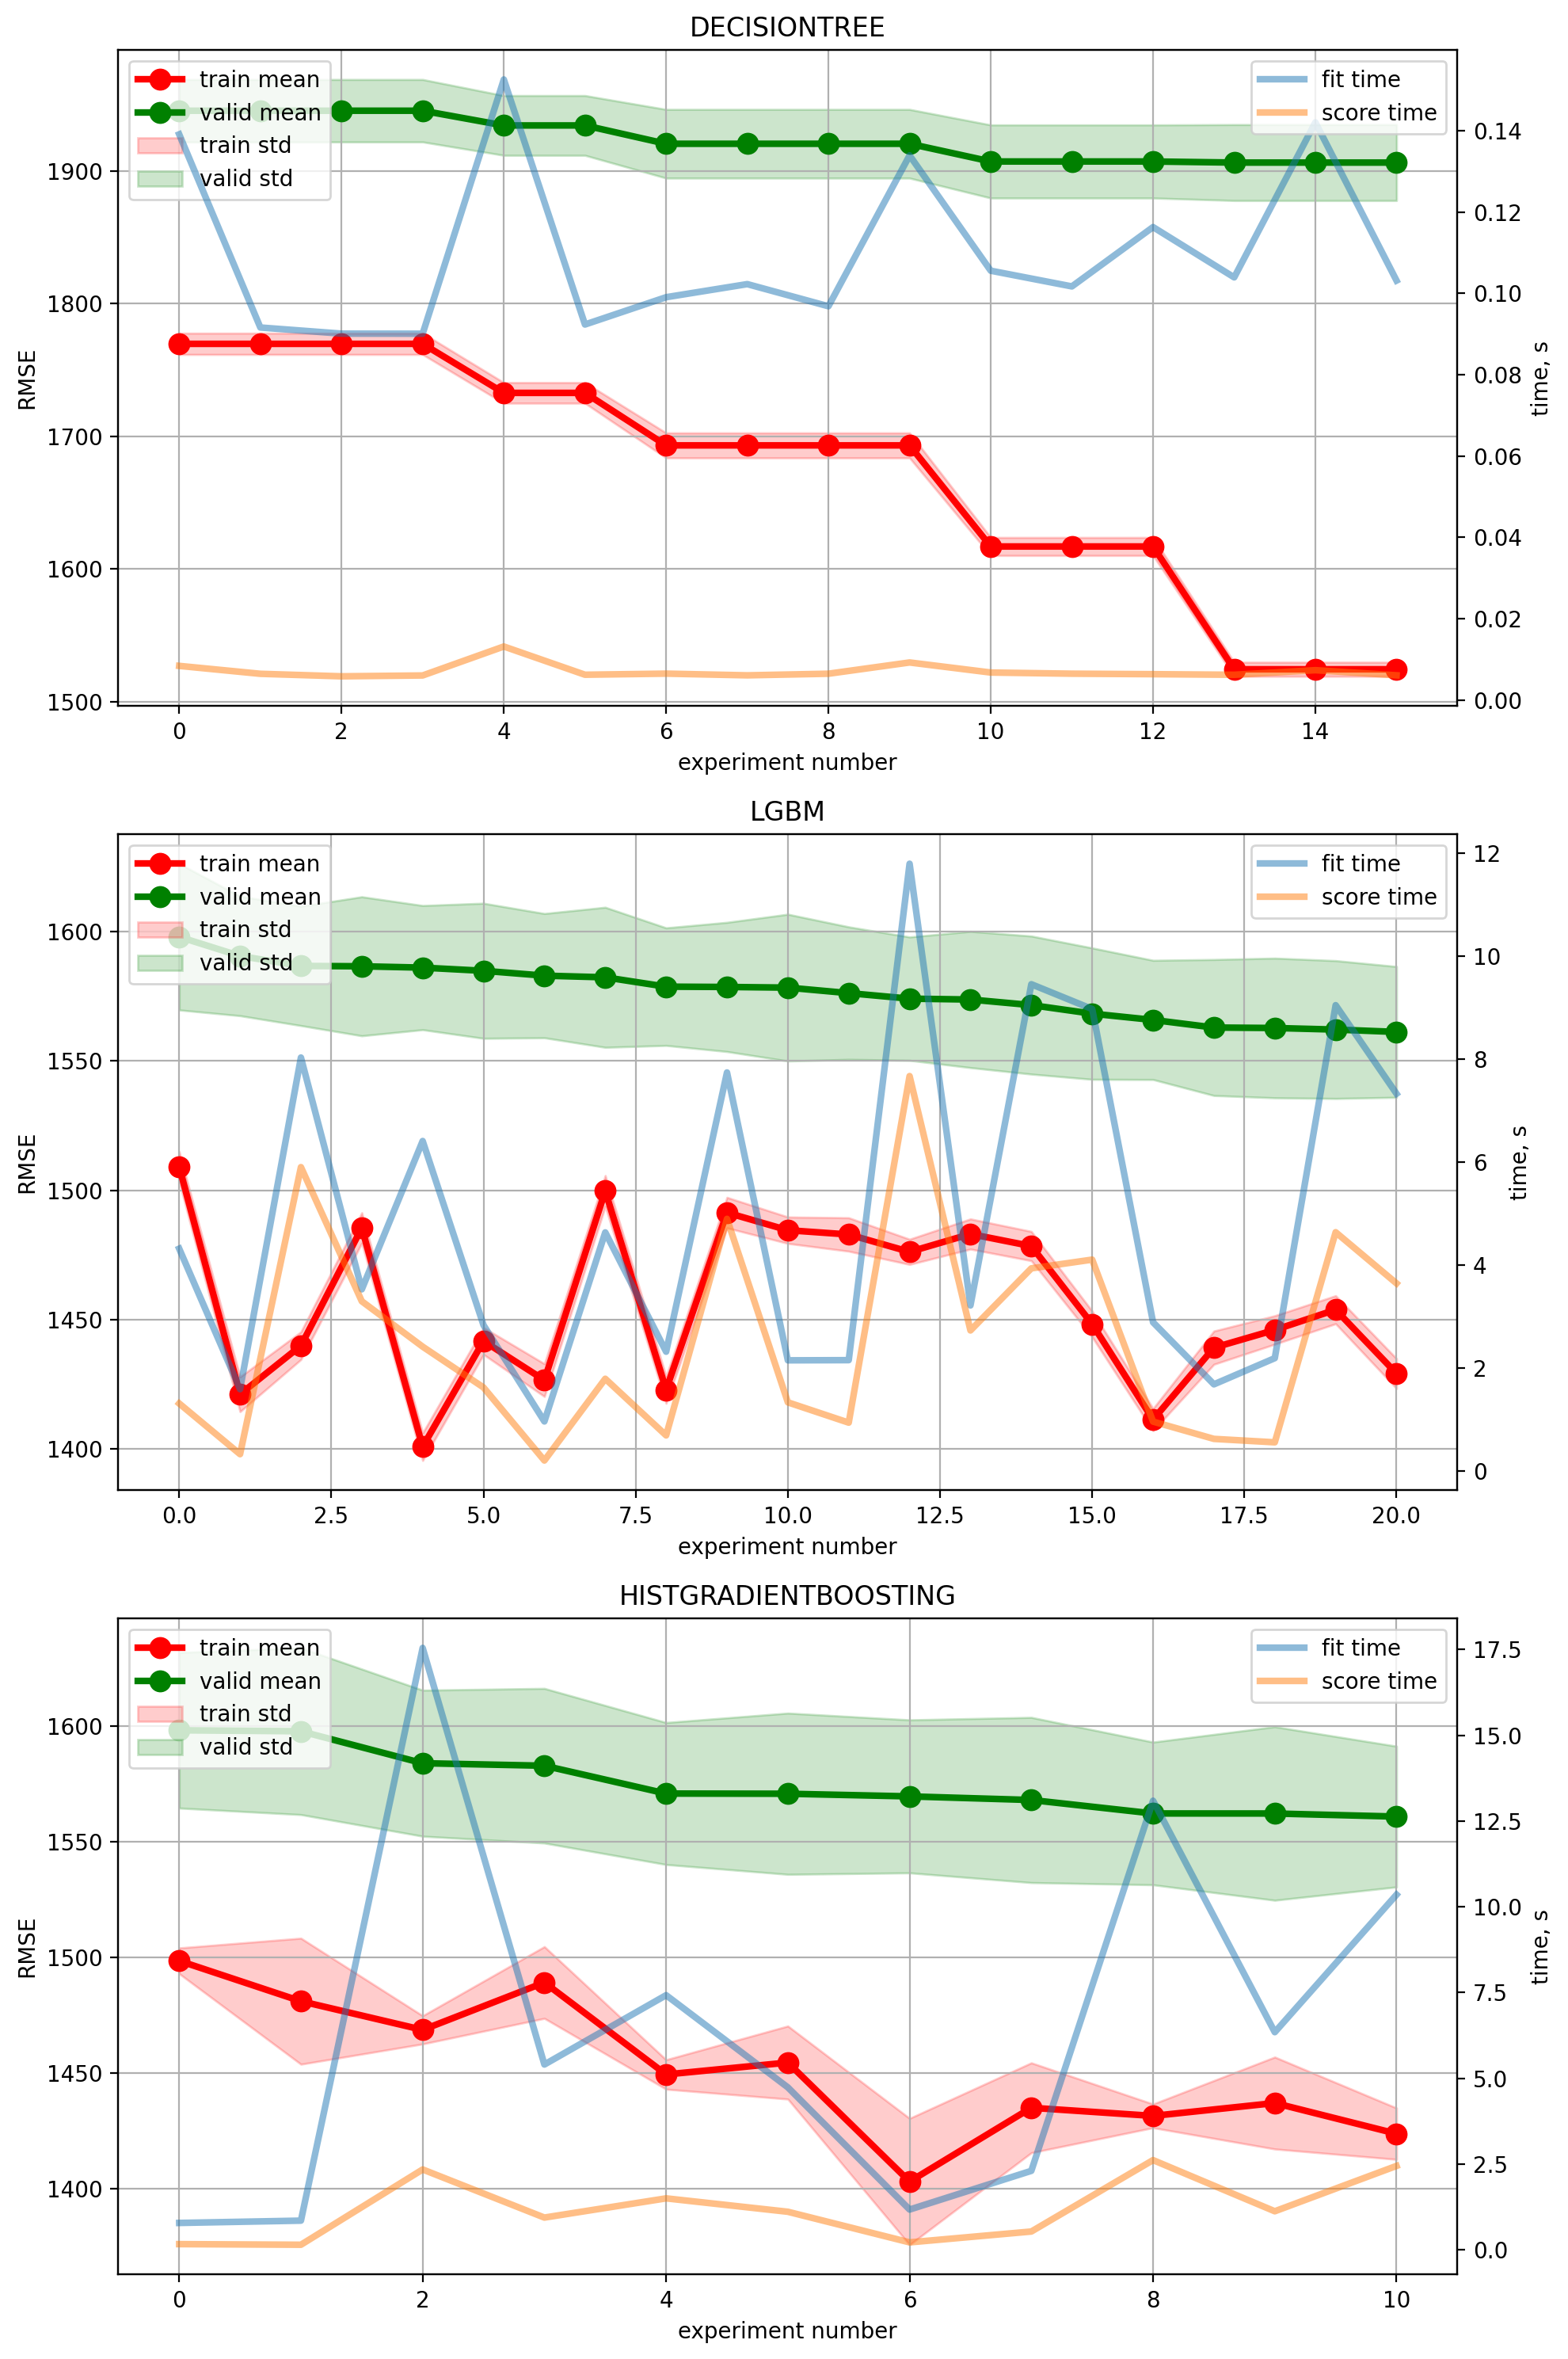

In [114]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plot_searh_curve(dt_results, ax=axes[0], model_name='DecisionTree')
plot_searh_curve(lgbm_results, ax=axes[1], model_name='LGBM')
plot_searh_curve(hgbr_results, ax=axes[2], model_name='HistGradientBoosting')
plt.tight_layout()
plt.show()

Выберем в качестве победителей эксперименты справа, у которых меньше RMSE при обучении, так мы уменьшим переобучение. Также учтем время на обучение.

В нашем случае для DecisionTree выберем пятый эксперимент справа, для LGBM — первый справа, для HistGradientBoosting — третий справа эксперимент. 

In [115]:
dt_best_idx = -5
lgbm_best_idx = -1
hgbr_best_idx = -3

Изучим результаты экспериментов.

In [116]:
_cols = hgbr_results.columns.to_list()
_cols.remove('params')
_cols.remove('rank_test_score')

dt_best_params = dt_results.iloc[[dt_best_idx]].params.values[0]
lgbm_best_params = lgbm_results.iloc[[lgbm_best_idx]].params.values[0]
hgbr_best_params = hgbr_results.iloc[[hgbr_best_idx]].params.values[0]

comparison = pd.concat([
    dt_results.iloc[[dt_best_idx]], lgbm_results.iloc[[lgbm_best_idx]],
    hgbr_results.iloc[[hgbr_best_idx]]
])[_cols].T
comparison.columns = ['DecisionTree', 'LGBM', 'HistGradientBoosting']

comparison

,DecisionTree,LGBM,HistGradientBoosting
mean_fit_time,0.101699,7.333516,13.092121
std_fit_time,0.002542,0.721373,0.350145
mean_score_time,0.006487,3.650163,2.617821
std_score_time,0.000690,1.217671,0.085003
mean_test_score,-1907.271528,-1561.232209,-1562.339134
std_test_score,27.577222,25.300519,30.889117
mean_train_score,-1616.883795,-1429.128307,-1431.435888
std_train_score,6.811582,5.770529,5.124604


Сделаем визуальный анализ результатов.

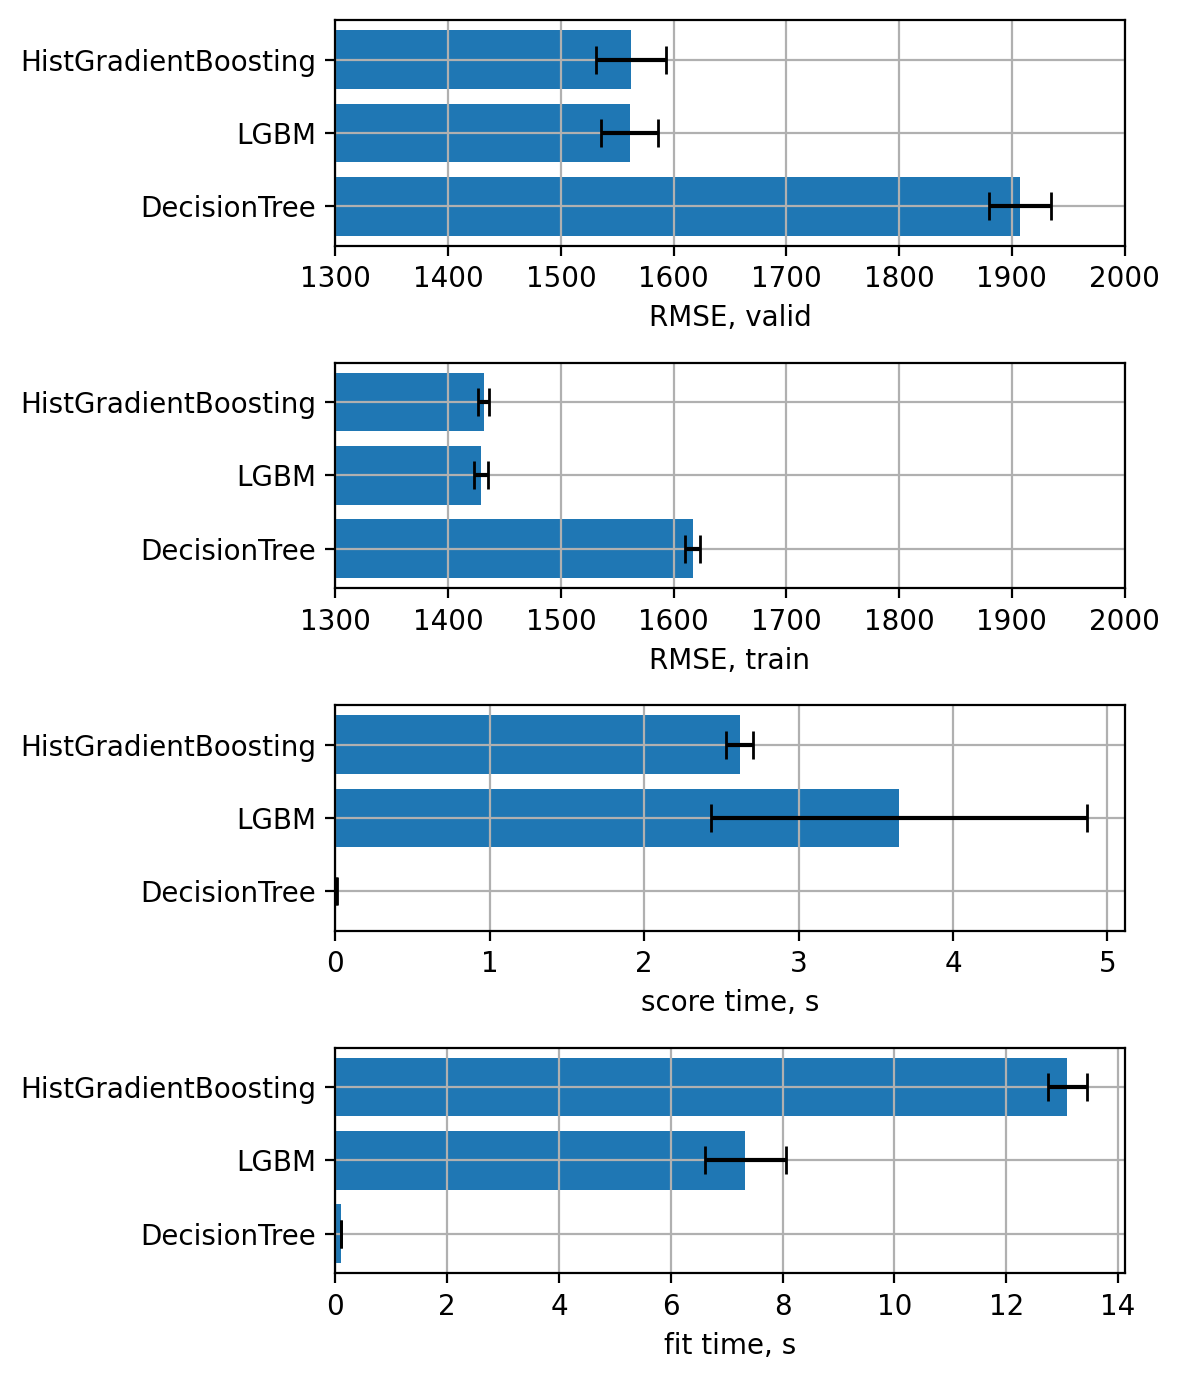

In [117]:
fig, axes = plt.subplots(4, 1, figsize=(6, 7))

labels = comparison.columns.to_list()
y_pos = range(len(labels))

plot_comaprison_bar(axes[0], -1 * comparison.loc["mean_test_score"].values,
                    comparison.loc["std_test_score"].values, labels,
                    "RMSE, valid", xlim=(1300,2000))

plot_comaprison_bar(axes[1], -1 * comparison.loc["mean_train_score"].values,
                    comparison.loc["std_train_score"].values, labels,
                    "RMSE, train", xlim=(1300,2000))

plot_comaprison_bar(axes[2], comparison.loc["mean_score_time"].values,
                    comparison.loc["std_score_time"].values, labels,
                    "score time, s")

plot_comaprison_bar(axes[3], comparison.loc["mean_fit_time"].values,
                    comparison.loc["std_fit_time"].values, labels,
                    "fit time, s")

plt.tight_layout()
plt.show()

Подбор гиперпараметров позволил нам немного уменьшить валидационный RMSE и увеличить RMSE на обучающей выборке, то есть уменьшить эффект от переобучения модели.

Мы видим, что DecisionTree по-прежнему остается самым быстрым из рассмотренных решений, но сильно уступает по качеству предсказания. Тем не менее результаты дерева решений удовлетворяют заданию — RMSE меньше 2500. Если критичным показателем является время, надо выбирать эту модель.

HistGradientBoosting и LGBM тают одинаковое качество предсказания, при этом LGBM дольше предсказывает и быстрее обучается. 

В качестве финалистов выберем эти две модели. Если нам нужно меньшее время предсказания, применим HistGradientBoosting. Если меньше время обучения — LGBM.

### Обучение на полных данных

Посмотрим на значения гиперпараметров в победивших экспериментах.

In [118]:
(dt_best_params, lgbm_best_params, hgbr_best_params)

({'min_samples_split': 32, 'min_samples_leaf': 8, 'max_depth': 500},
 {'subsample_freq': 5,
  'subsample': 0.3,
  'reg_lambda': 162.3776739188721,
  'num_leaves': 256,
  'n_estimators': 900,
  'min_child_samples': 50,
  'learning_rate': 0.04281332398719394,
  'colsample_bytree': 1},
 {'min_samples_leaf': 150,
  'max_leaf_nodes': 32,
  'max_iter': 1100,
  'learning_rate': 0.01438449888287663,
  'l2_regularization': 54.55594781168517})

Выполним преобразование обучающей и тестовой выборок: кодирование категориальных признаков и масштабирование численных. Для преобразования применим сохраненный `ColumnTransformer`.

In [119]:
ordinal_transformer.fit(X_train)

X_train = pd.DataFrame(ordinal_transformer.transform(X_train),
                        columns=categorical_features + numerical_features)
X_test = pd.DataFrame(ordinal_transformer.transform(X_test),
                        columns=categorical_features + numerical_features)

for column in categorical_features:
    X_train[column] = pd.Categorical(X_train[column])
    X_test[column] = pd.Categorical(X_test[column])

In [120]:
X_train.shape, y_train.shape

((202089, 8), (202089,))

In [121]:
X_test.shape, y_test.shape

((51242, 8), (51242,))

Выборки готовы, обучим модели.

In [122]:
lgbm_model = LGBMRegressor(**lgbm_best_params, random_state=RANDOM_STATE)

lgbm_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=1, learning_rate=0.04281332398719394,
              min_child_samples=50, n_estimators=900, num_leaves=256,
              random_state=RandomState(MT19937) at 0x7FD274CA9240,
              reg_lambda=162.3776739188721, subsample=0.3, subsample_freq=5)

In [123]:
hgbr_model = HistGradientBoostingRegressor(**hgbr_best_params,
        categorical_features=categorical_mask, random_state=RANDOM_STATE)

hgbr_model.fit(X_train, y_train)

HistGradientBoostingRegressor(categorical_features=[True, True, True, True,
                                                    True, False, False, False],
                              l2_regularization=54.55594781168517,
                              learning_rate=0.01438449888287663, max_iter=1100,
                              max_leaf_nodes=32, min_samples_leaf=150,
                              random_state=RandomState(MT19937) at 0x7FD274CA9240)

Проверим качество предсказания на обучающей выборке.

In [124]:
lgbm_train_predictions = lgbm_model.predict(X_train)

hgbr_train_predictions = hgbr_model.predict(X_train)

Результаты LGBM

In [125]:
lgbm_train_rmse = mean_squared_error(y_train, lgbm_train_predictions, squared=False)
print(f"LGBM RMSE (train): {lgbm_train_rmse}")

LGBM RMSE (train): 1341.7284458641989


In [126]:
hgbr_train_rmse = mean_squared_error(y_train, hgbr_train_predictions, squared=False)
print(f"HistGradientBoosting RMSE (train): {hgbr_train_rmse}")

HistGradientBoosting RMSE (train): 1437.1447769913887


### Вывод

Мы проверили модель на состоятельность и убедились, что выбранные методы очистки и подготовки данных положительно повлияли на качество модели. 

Мы проанализировали влияние признаков на качество предсказания и выбрали только значимые признаки.

Мы проанализировали качество предсказания, время обучения и предсказания для четырех алгоритмов: линейной регрессии, дерева решений, LGBM и HistGradientBoosting.

Для дерева решений, LGBM и HistGradientBoosting мы подобрали гиперпараметры, обеспечивающие точность и защиту от переобучения модели. 

В результате мы получили две модели с сопоставимым качеством предсказания на основе алгоритмов LGBM и HistGradientBoosting. Цель получить модель с RMSE меньше 2500 достигнута. Наши модели на валидационной выборке имеют RMSE 1561 +/- 25.


## Тестирование моделей

Выполним тестирование обученных моделей на тестовой выбрке.

In [127]:
lgbm_test_predictions = lgbm_model.predict(X_test)

hgbr_test_predictions = hgbr_model.predict(X_test)

In [128]:
lgbm_test_rmse = mean_squared_error(y_test, lgbm_test_predictions, squared=False)
print(f"LGBM RMSE (test): {lgbm_test_rmse}")

LGBM RMSE (test): 1430.7586495644614


In [129]:
hgbr_test_rmse = mean_squared_error(y_test, hgbr_test_predictions, squared=False)
print(f"HistGradientBoosting RMSE (test): {hgbr_test_rmse}")

HistGradientBoosting RMSE (test): 1481.9246196460826


Видим, что увеличение размера обучающей выборки положительно сказалось на качестве предсказания. Подобранные гиперпараметры не дали моделям переобучиться, мы получили близкие значения RMSE на обучающей и тестовой выборке.

## Вывод

Мы разработали модели предсказания цены автомобиля и обеспечили заданный уровень качества предсказания. Полученные модели продемонстрировали RMSE на тестовой выборке 1464 и 1481 при требуемом RMSE не более 2500.

Для достижения поставленной цели мы проанализировали данные и определили область применения модели:
- возраст автомобиля от 4 до 20 лет включительно,
- обязательно наличие информации о типе автомобильного кузова и моодели,
- мощность автомобиля от 50 до 250 лс включительно,
- минимальная стоимость 300 евро.

Мы сравнили 4 модели по качеству предсказания, времени обучения и времени предсказания и выбрали две сопоставимые по качеству, отличающиеся по времени обучения и предсказания. Выбор между финальными моделями можно сделать исходя из приоритетов качества предсказания, времени обучения и времени предсказания.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей